# Evaluation vorticity 8x -> 2.2km
## Diff model

**Cleaned code version**

Vorticity transform: standardize (based on train set mean and std) then devide by standardized train set max

Target transform: sqrt then divide by sqrted train set max

Sample inverse transform: multiply by train set max, clip negative values to 0 then square

In [1]:
%reload_ext autoreload

%autoreload 2

import math
import os

import iris
import iris.analysis.cartography
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

from ml_downscaling_emulator import UKCPDatasetMetadata
from ml_downscaling_emulator.helpers import plot_over_ts
from ml_downscaling_emulator.utils import cp_model_rotated_pole, platecarree, plot_grid

In [2]:
split = "val"
dataset_name = "2.2km-coarsened-8x_london_vorticity850_random"

In [5]:
run_name = "2.2km-coarsened-8x_london_vorticity850_random-transform-data-cleancode"
checkpoint_id = 100

pred_ds = xr.open_mfdataset(os.path.join(os.getenv("DERIVED_DATA"), 'score-sde/workdirs/subvpsde/xarray_cncsnpp_continuous', run_name, f'samples/checkpoint-{checkpoint_id}', split, 'predictions-*.nc')).isel(grid_latitude=slice(32), grid_longitude=slice(32))
orig_pred_ds = xr.open_mfdataset(os.path.join(os.getenv("DERIVED_DATA"), 'score-sde/workdirs/subvpsde/xarray_cncsnpp_continuous', run_name, f'samples/checkpoint-{checkpoint_id}', f"{split}-orig", 'predictions-*.nc')).isel(grid_latitude=slice(32), grid_longitude=slice(32))
preclean_pred_ds = xr.open_mfdataset(os.path.join(os.getenv("DERIVED_DATA"), 'score-sde/workdirs/subvpsde/xarray_cncsnpp_continuous', "2.2km-coarsened-8x_london_vorticity850_random-transform-data", f'samples/checkpoint-200', split, 'predictions-*.nc')).isel(grid_latitude=slice(32), grid_longitude=slice(32))
orig_preclean_pred_ds = xr.open_mfdataset(os.path.join(os.getenv("DERIVED_DATA"), 'score-sde/workdirs/subvpsde/xarray_cncsnpp_continuous', "2.2km-coarsened-8x_london_vorticity850_random-transform-data", f'samples/checkpoint-200', f"{split}-orig", 'predictions-*.nc')).isel(grid_latitude=slice(32), grid_longitude=slice(32))
retrain_pred_ds = xr.open_mfdataset(os.path.join(os.getenv("DERIVED_DATA"), 'score-sde/workdirs/subvpsde/xarray_cncsnpp_continuous', "2.2km-coarsened-8x_london_vorticity850_random-transform-data-cleancode-rerun", f'samples/checkpoint-100', split, 'predictions-*.nc')).isel(grid_latitude=slice(32), grid_longitude=slice(32))
shared_env_pred_ds = xr.open_mfdataset(os.path.join(os.getenv("DERIVED_DATA"), 'score-sde/workdirs/subvpsde/xarray_cncsnpp_continuous', "2.2km-coarsened-8x_london_vorticity850_random-mlde-env", f'samples/checkpoint-20', split, 'predictions-*.nc')).isel(grid_latitude=slice(32), grid_longitude=slice(32))
eval_ds = xr.open_dataset(os.path.join(os.getenv("MOOSE_DERIVED_DATA"), "nc-datasets", dataset_name, f"{split}.nc")).isel(grid_latitude=slice(32), grid_longitude=slice(32))
train_ds = xr.open_dataset(os.path.join(os.getenv("MOOSE_DERIVED_DATA"), "nc-datasets", dataset_name, f"train.nc")).isel(grid_latitude=slice(32), grid_longitude=slice(32))

# convert from kg m-2 s-1 (i.e. mm s-1) to mm day-1
pred_ds["pred_pr"] = (pred_ds["pred_pr"]*3600*24 ).assign_attrs({"units": "mm day-1"})
orig_pred_ds["pred_pr"] = (orig_pred_ds["pred_pr"]*3600*24 ).assign_attrs({"units": "mm day-1"})
preclean_pred_ds["pred_pr"] = (preclean_pred_ds["pred_pr"]*3600*24 ).assign_attrs({"units": "mm day-1"})
orig_preclean_pred_ds["pred_pr"] = (orig_preclean_pred_ds["pred_pr"]*3600*24 ).assign_attrs({"units": "mm day-1"})
retrain_pred_ds["pred_pr"] = (retrain_pred_ds["pred_pr"]*3600*24 ).assign_attrs({"units": "mm day-1"})
shared_env_pred_ds["pred_pr"] = (shared_env_pred_ds["pred_pr"]*3600*24 ).assign_attrs({"units": "mm day-1"})
eval_ds["target_pr"] = (eval_ds["target_pr"]*3600*24).assign_attrs({"units": "mm day-1"})
train_ds["target_pr"] = (train_ds["target_pr"]*3600*24).assign_attrs({"units": "mm day-1"})

merged_ds = xr.merge([pred_ds, eval_ds])#, join="inner")

In [6]:
merged_ds

<xarray.Dataset>
Dimensions:                     (time: 4320, sample_id: 10, bnds: 2,
                                 grid_latitude: 32, grid_longitude: 32)
Coordinates:
  * time                        (time) object 1980-12-03 12:00:00 ... 2080-11...
    forecast_period             (time) timedelta64[ns] 452 days 12:00:00 ... ...
    forecast_reference_time     (time) object 1979-09-01 00:00:00 ... 2059-09...
    realization                 (time) int32 1100000 1100000 ... 1100000 1100000
    pressure                    (time) float32 850.0 850.0 850.0 ... 850.0 850.0
    season                      (time) int64 0 0 0 0 0 0 0 0 ... 3 3 3 3 3 3 3 3
  * grid_latitude               (grid_latitude) float32 -1.58 -1.56 ... -0.9599
  * grid_longitude              (grid_longitude) float32 360.9 360.9 ... 361.5
  * sample_id                   (sample_id) int64 0 1 2 3 4 5 6 7 8 9
Dimensions without coordinates: bnds
Data variables:
    rotated_latitude_longitude  (sample_id, time) float64 -2.147e+09 ... -2.1...
    time_bnds                   (sample_id, time, bnds) object 1980-12-03 00:...
    grid_latitude_bnds          (sample_id, time, grid_latitude, bnds) float32 ...
    grid_longitude_bnds         (sample_id, time, grid_longitude, bnds) float32 ...
    forecast_period_bnds        (sample_id, time, bnds) float64 1.085e+04 ......
    pred_pr                     (sample_id, time, grid_latitude, grid_longitude) float32 dask.array<chunksize=(1, 4320, 32, 32), meta=np.ndarray>
    target_pr                   (time, grid_latitude, grid_longitude) float32 ...
    vorticity850                (time, grid_latitude, grid_longitude) float64 ...

In [7]:
pred_pr = merged_ds["pred_pr"]
target_pr = merged_ds["target_pr"]

total_pred_pr = merged_ds["pred_pr"].sum(dim=["grid_longitude", "grid_latitude"])
total_target_pr = merged_ds["target_pr"].sum(dim=["grid_longitude", "grid_latitude"])

## Samples

In [8]:
sorted_time = merged_ds.sum(dim=['grid_latitude', 'grid_longitude']).sortby('target_pr')["time"].values

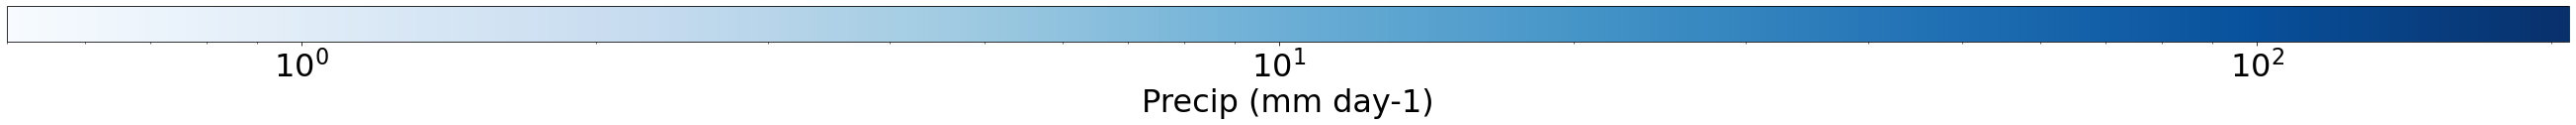

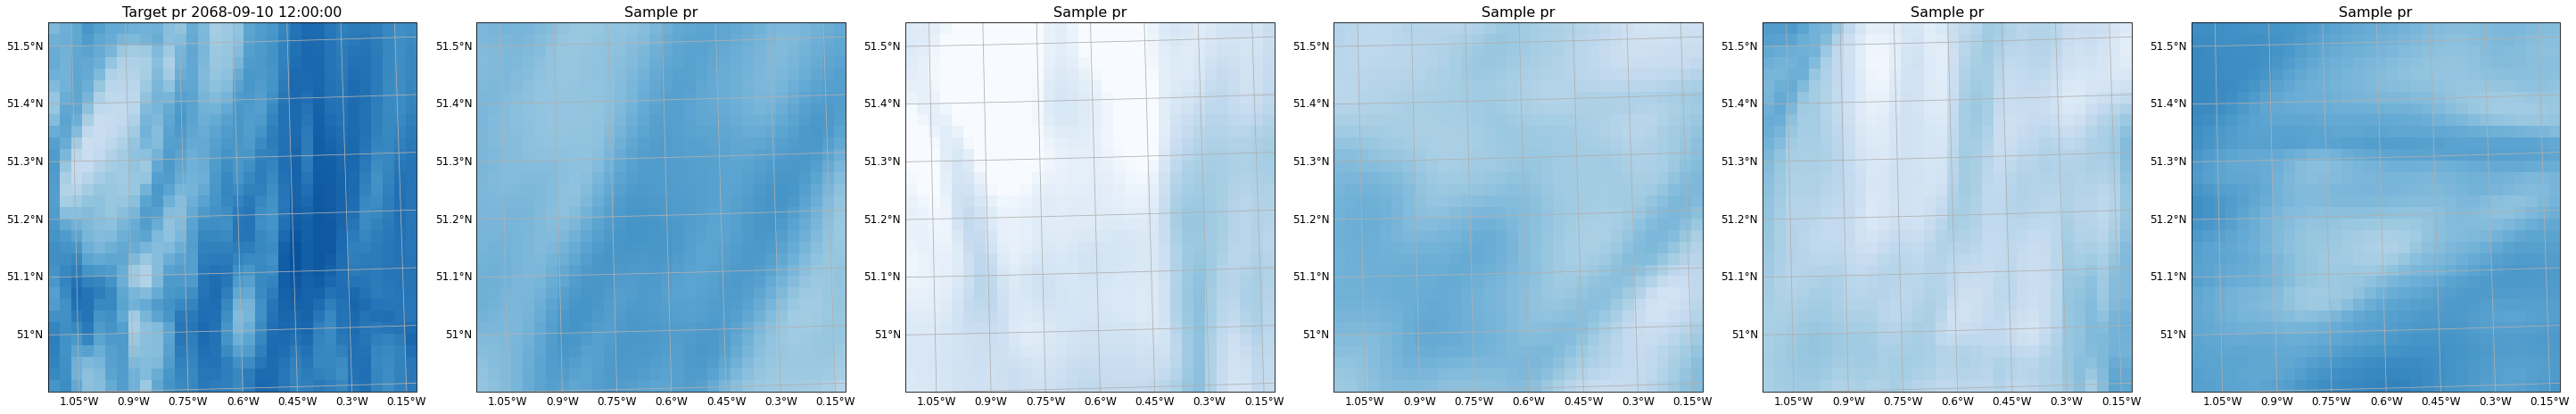

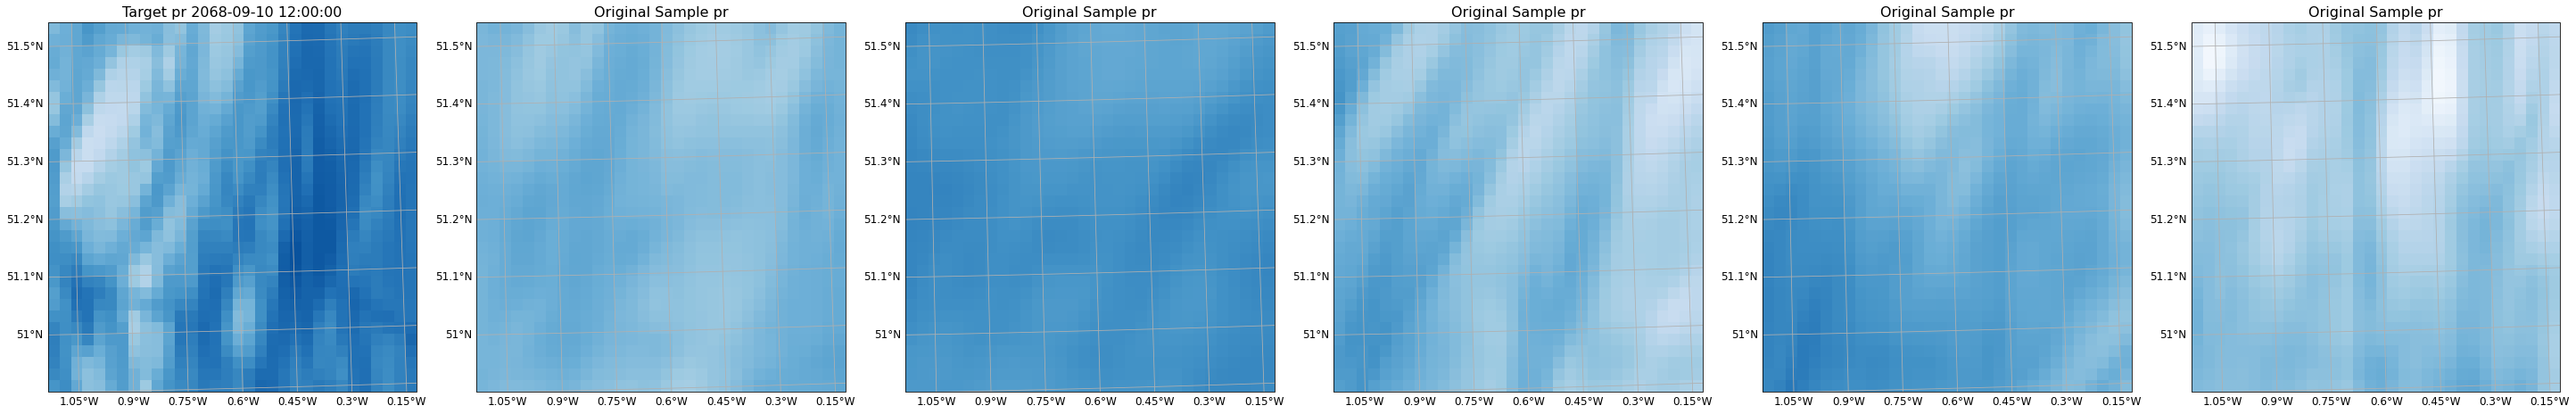

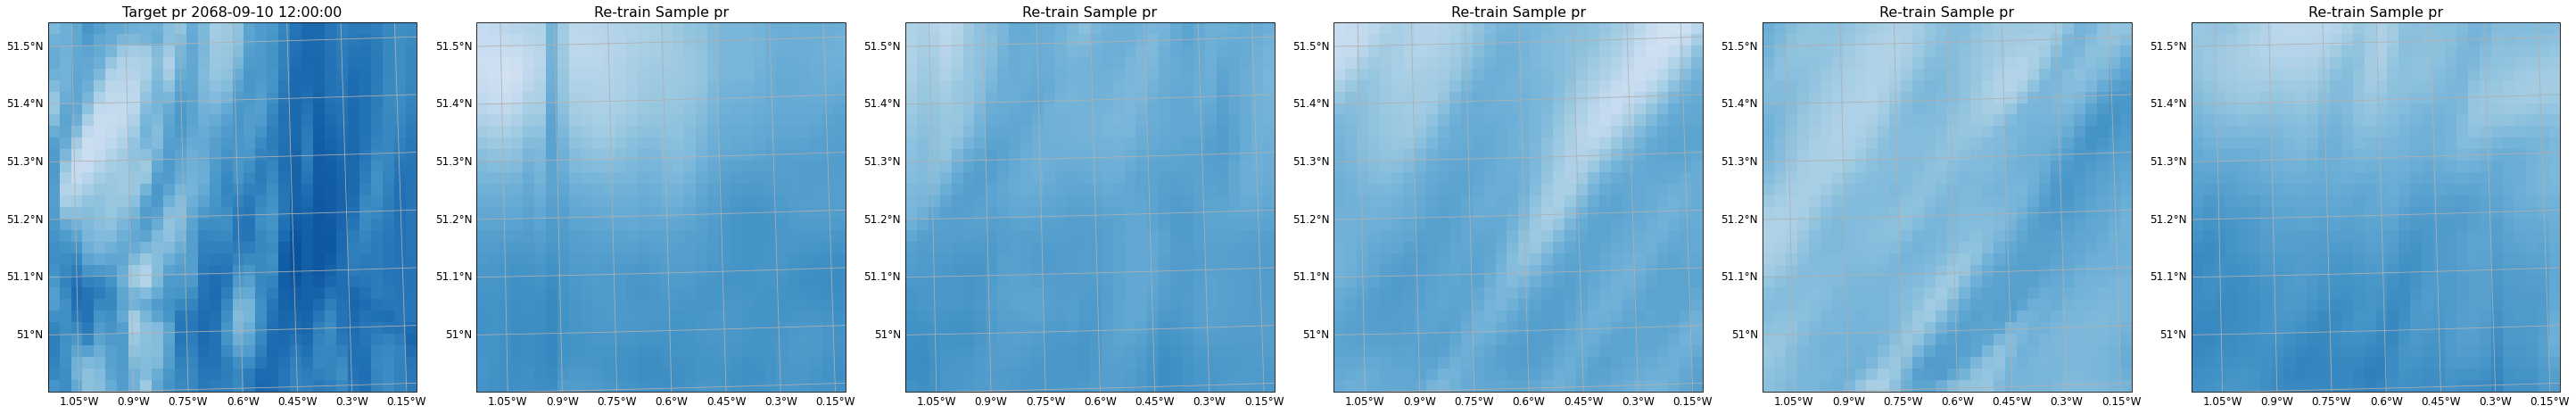

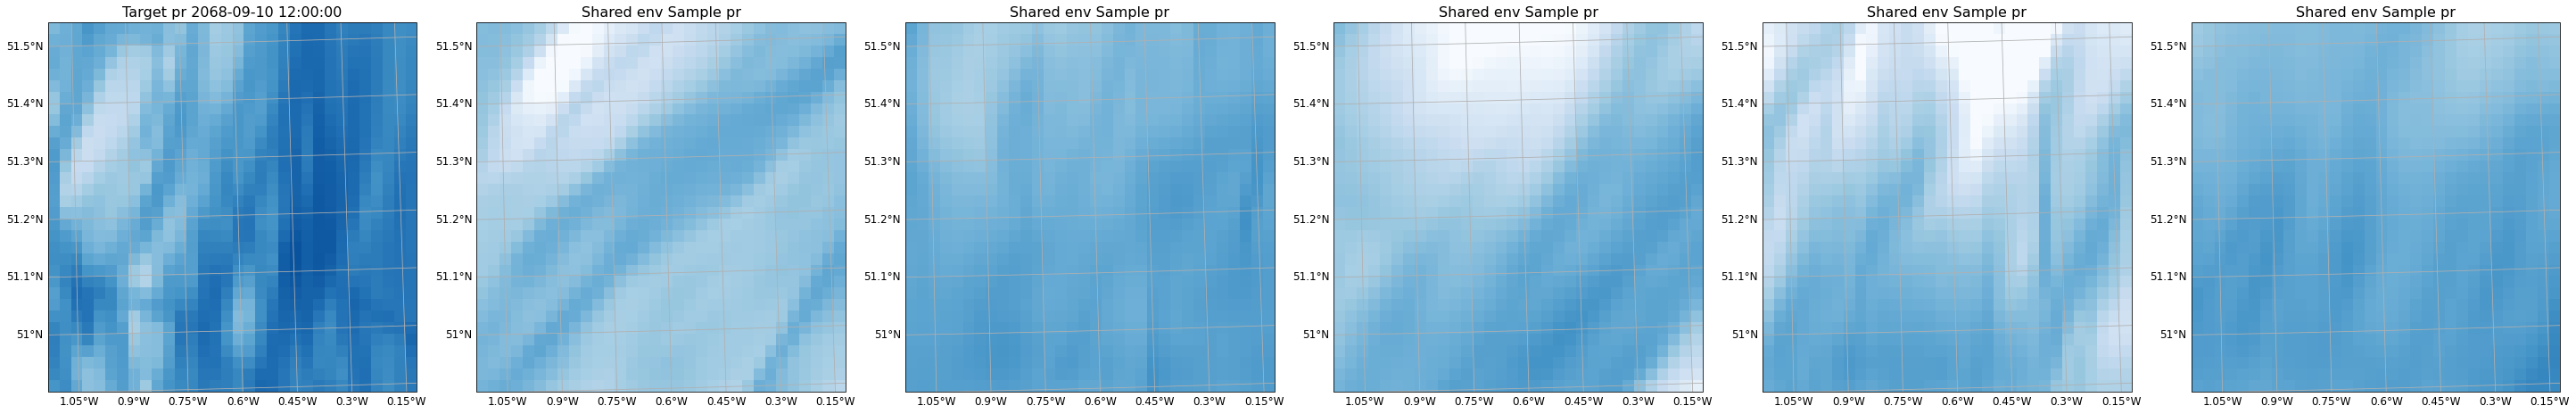

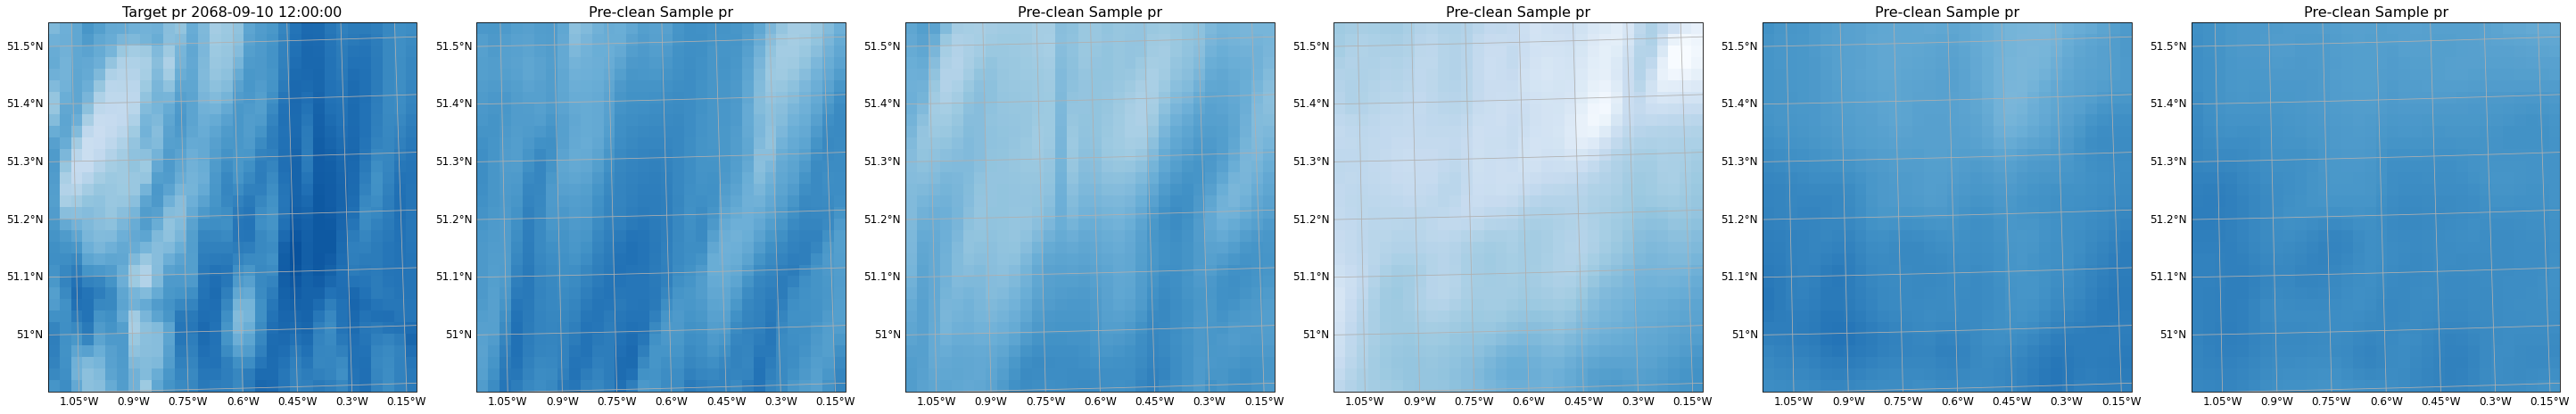

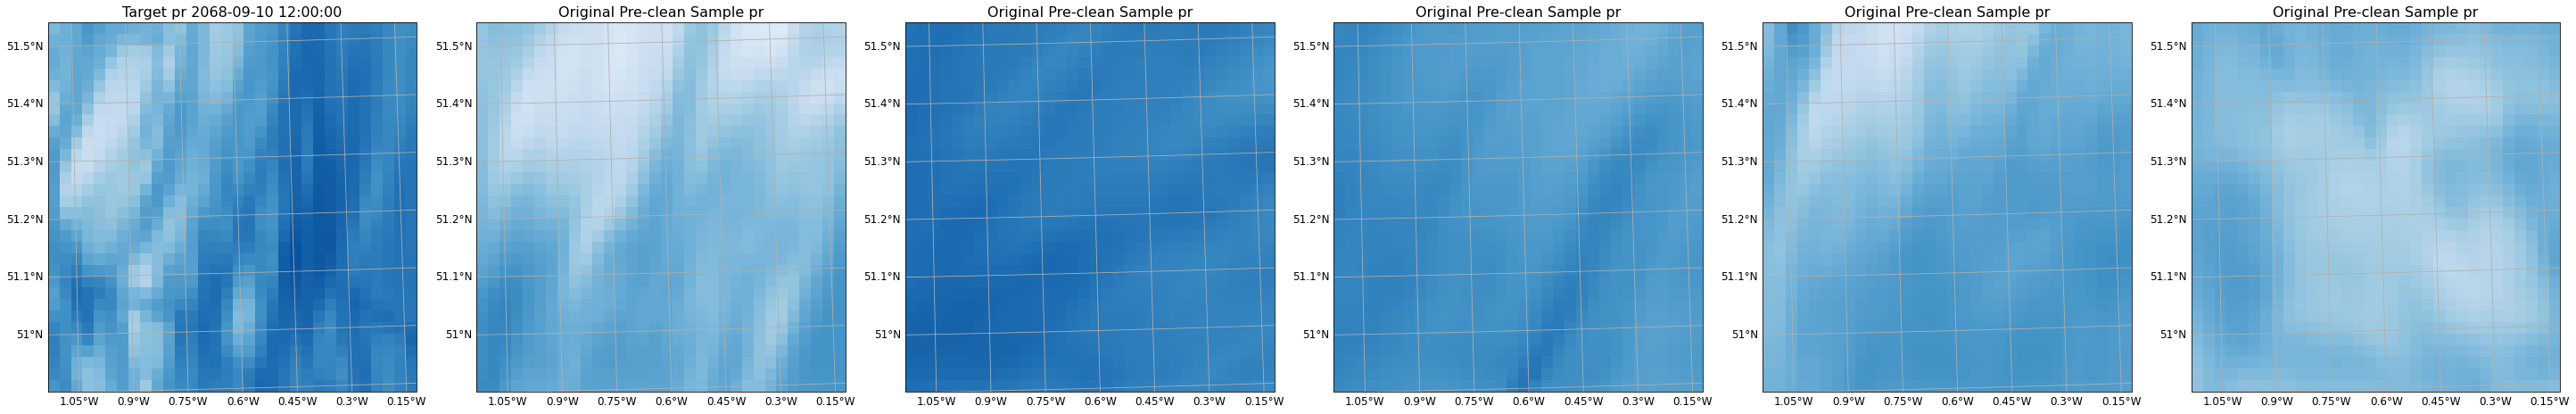

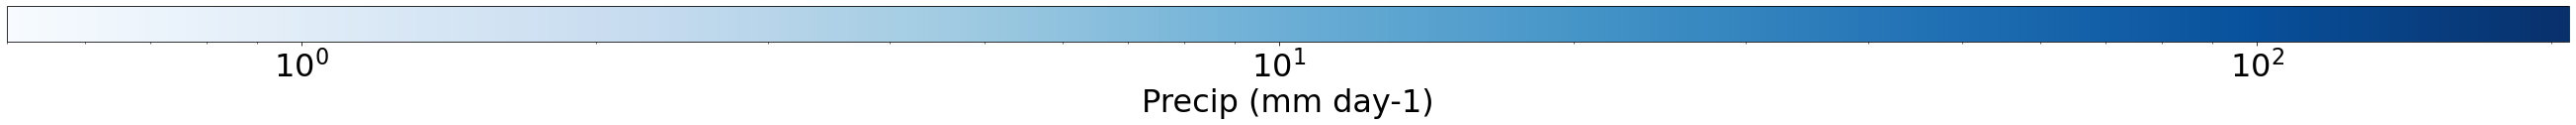

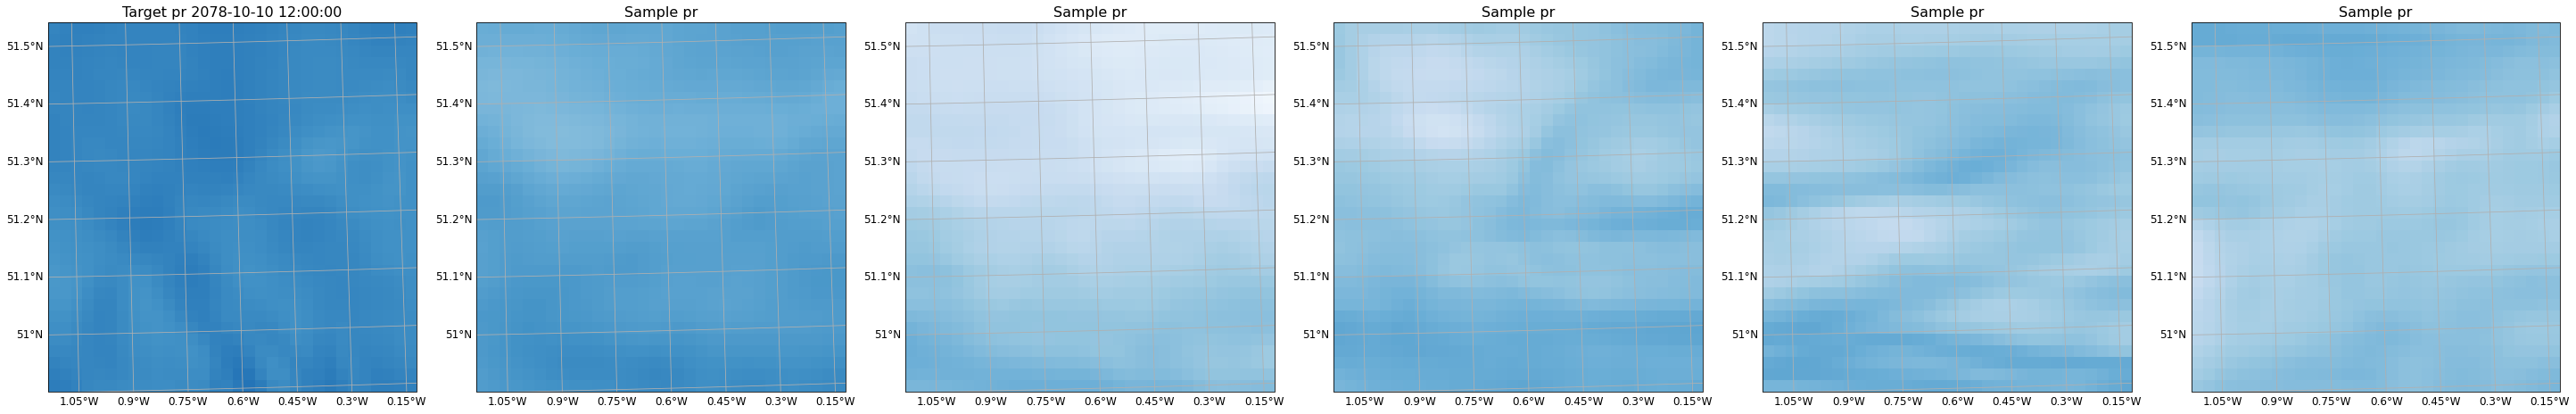

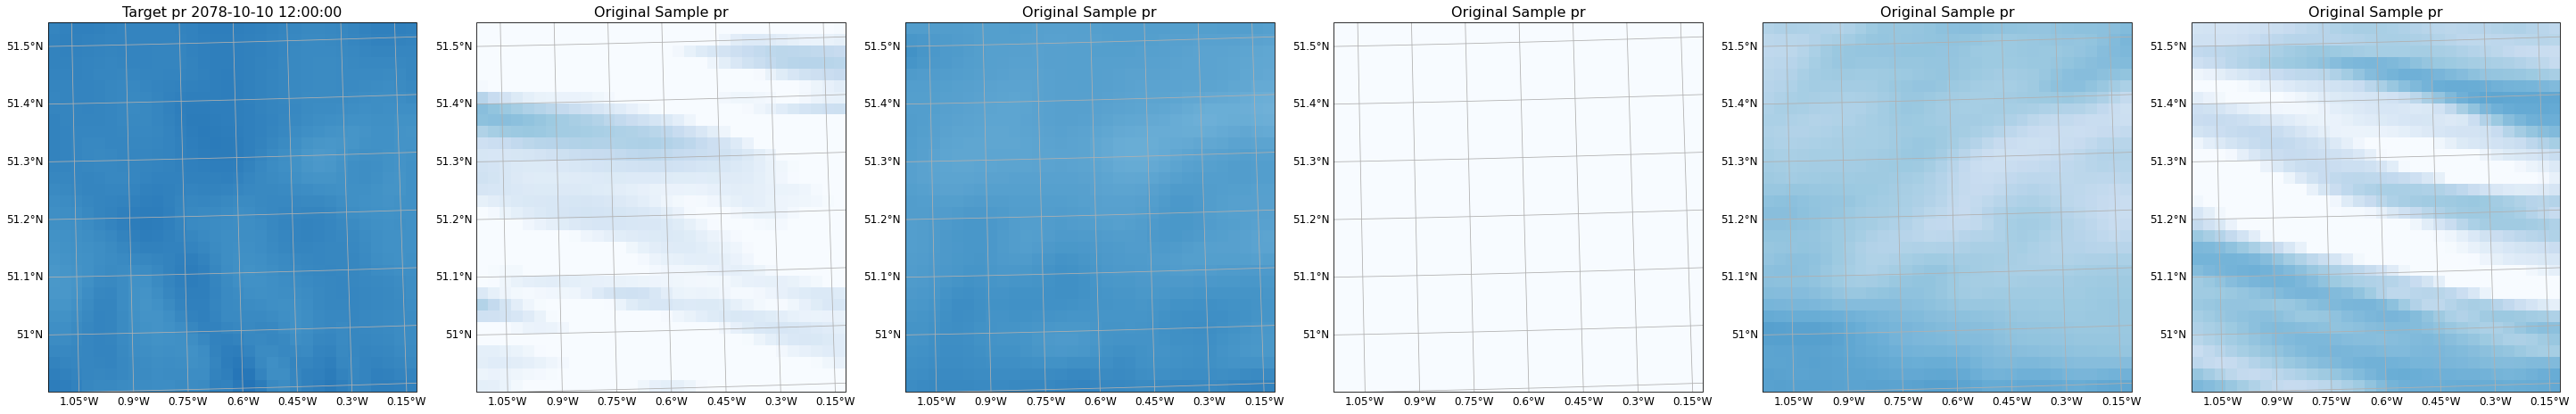

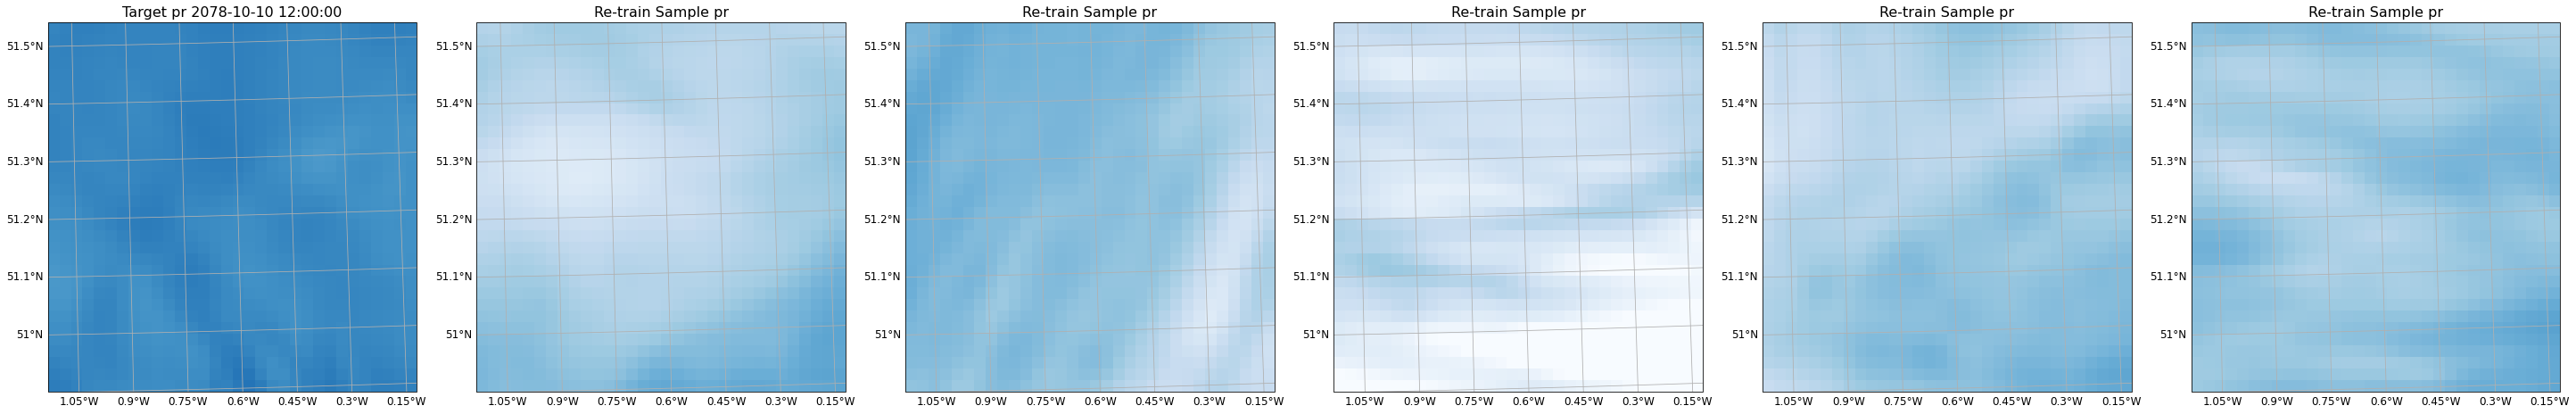

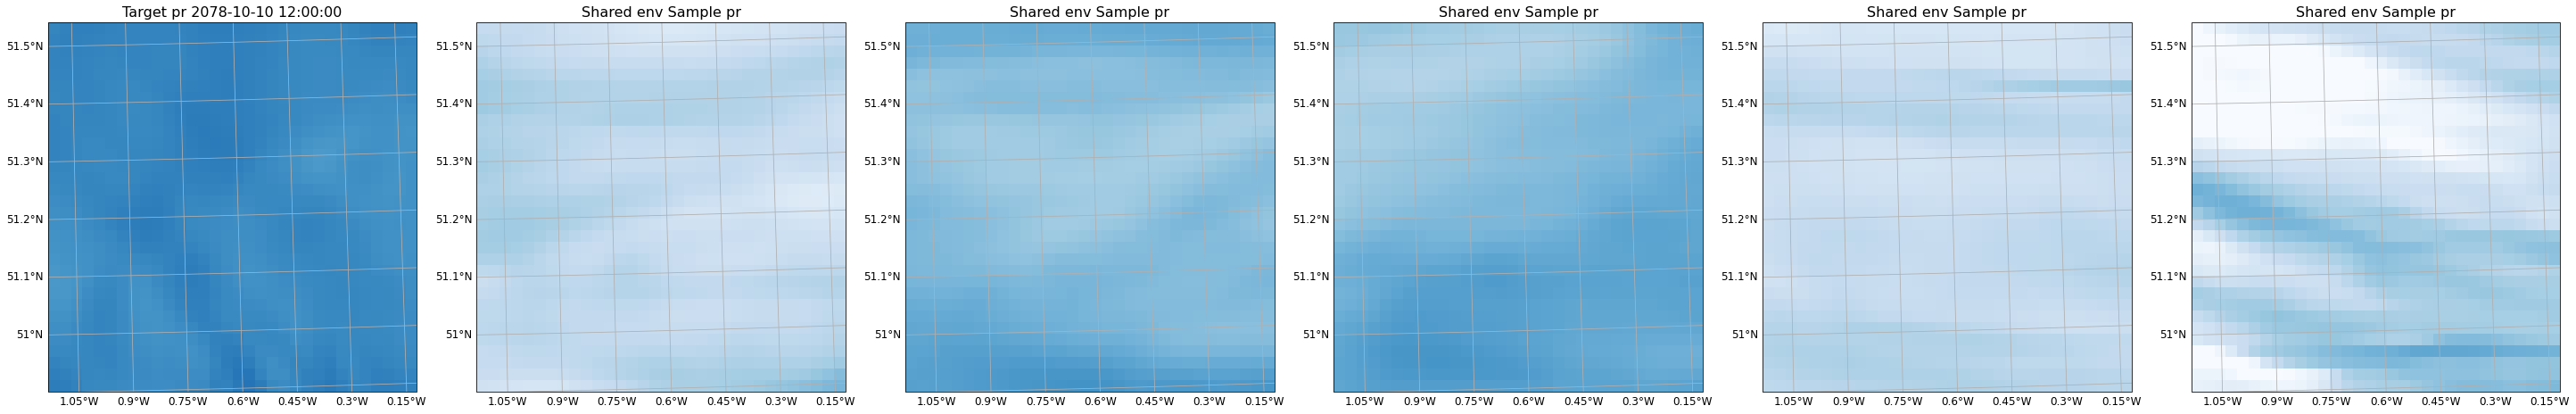

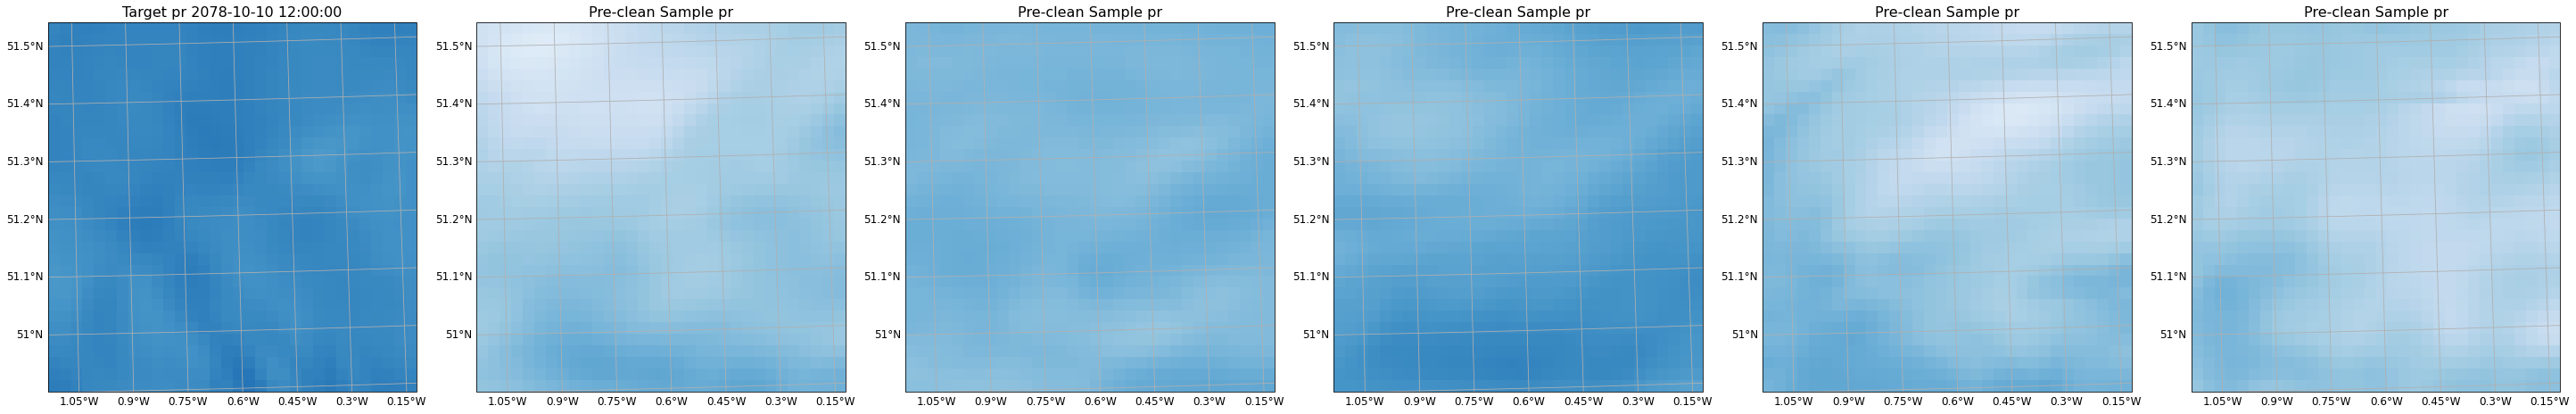

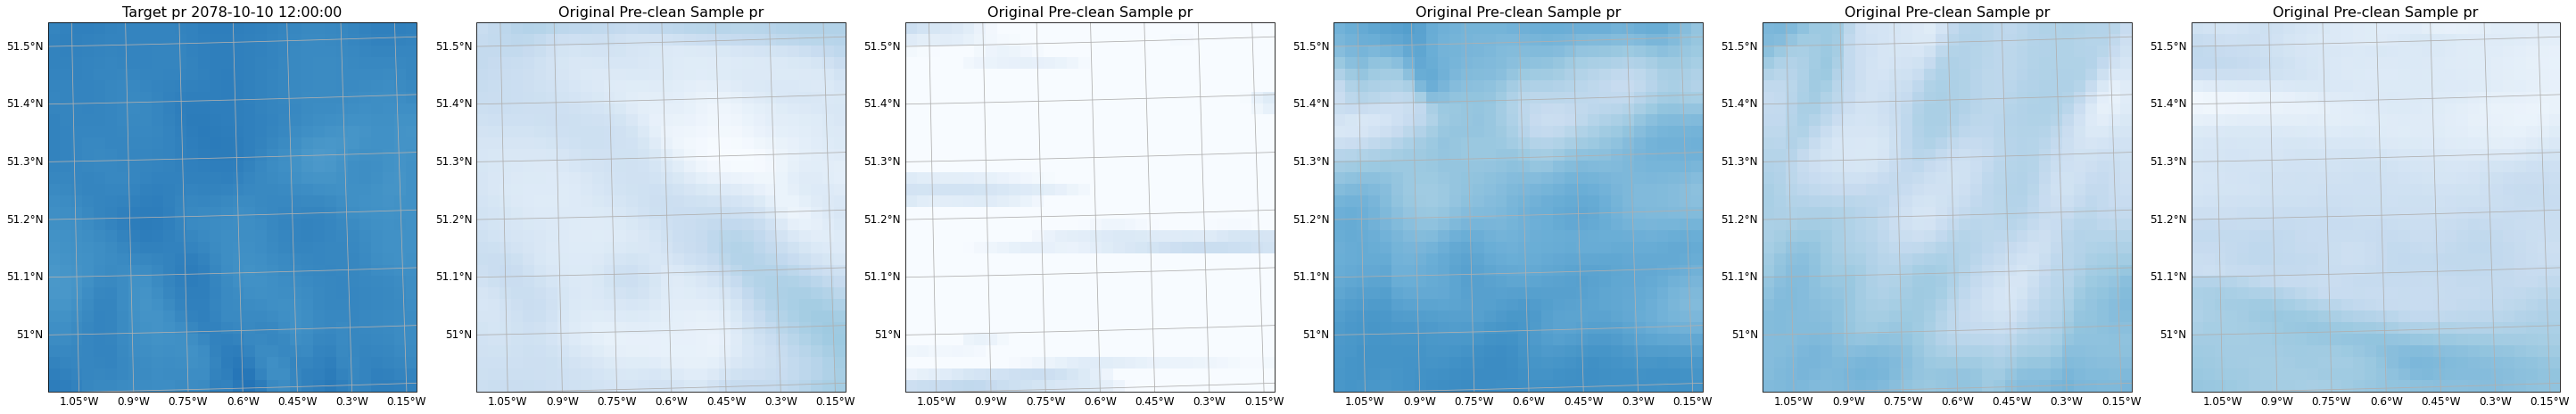

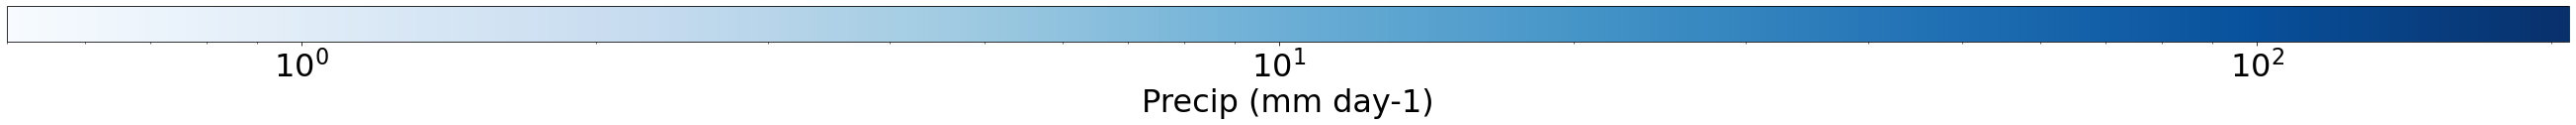

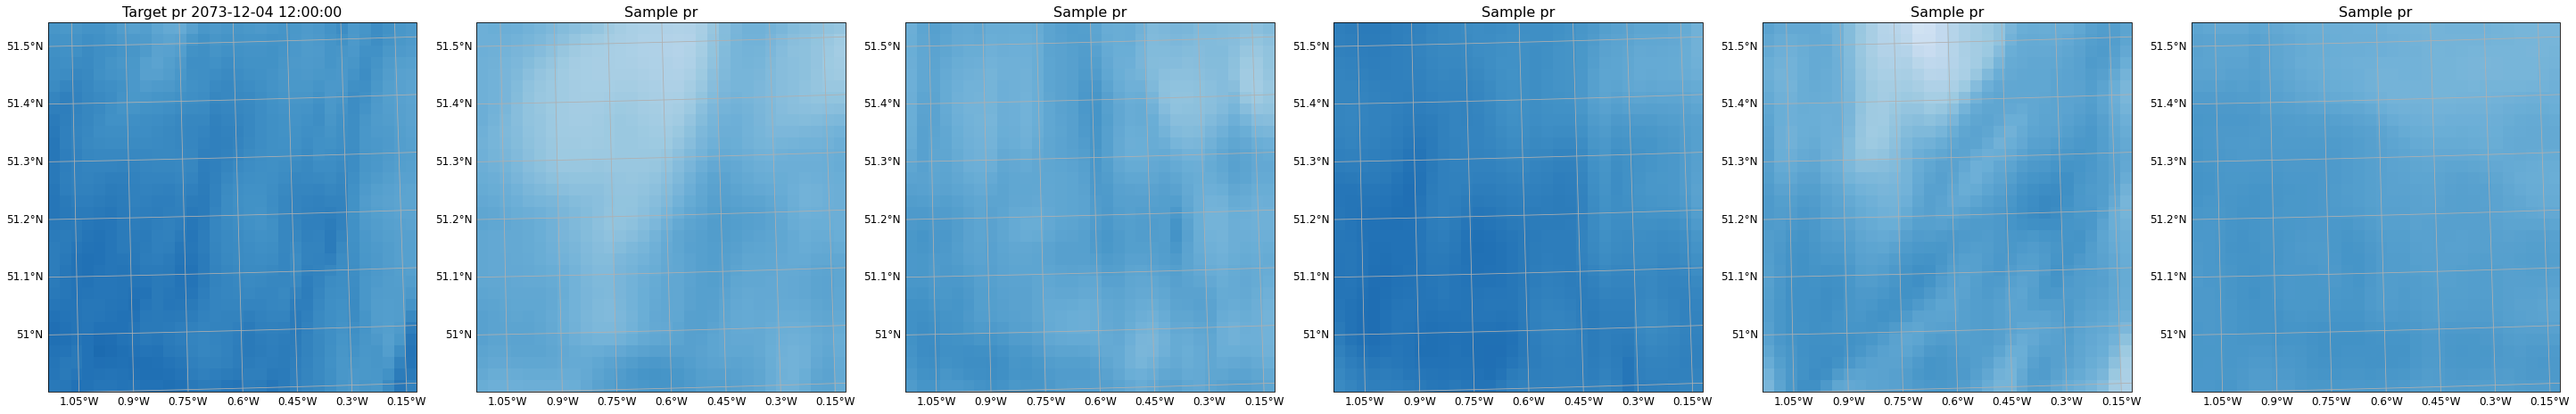

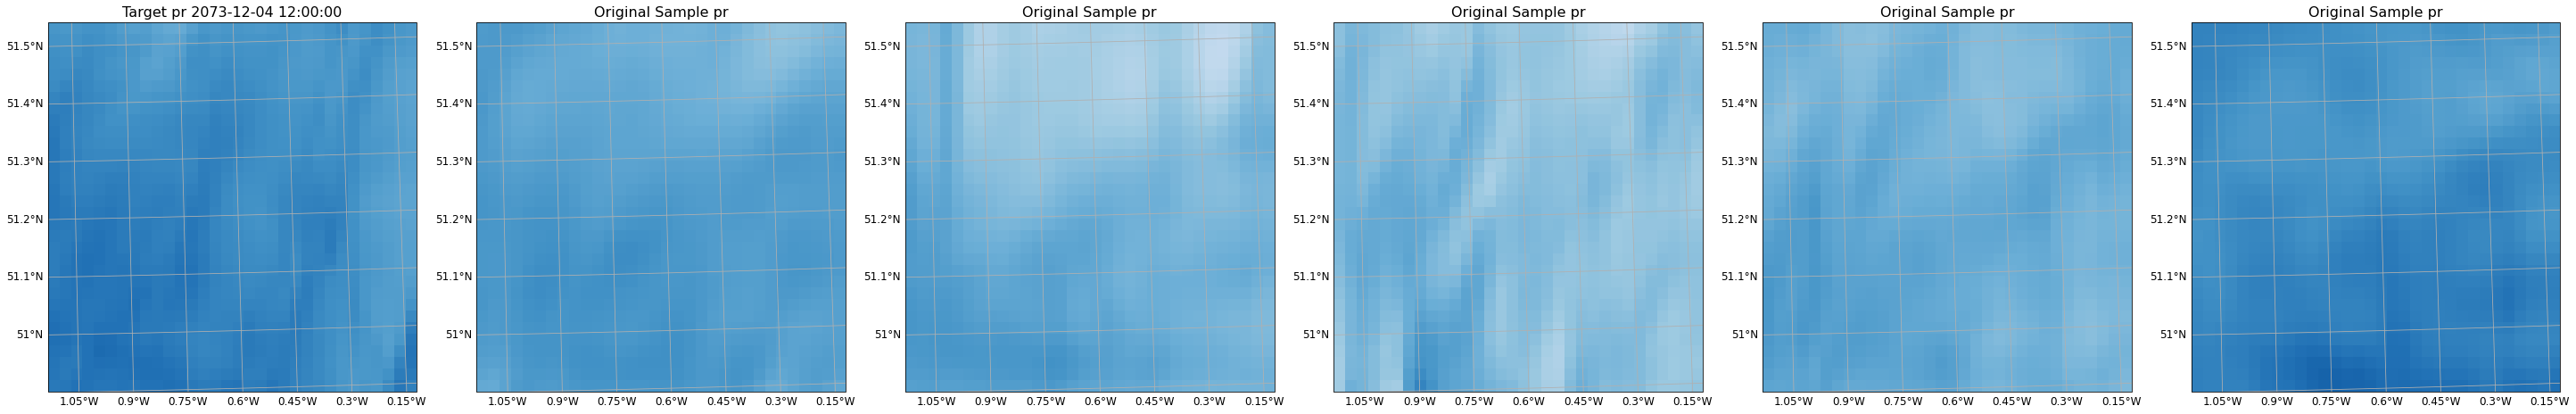

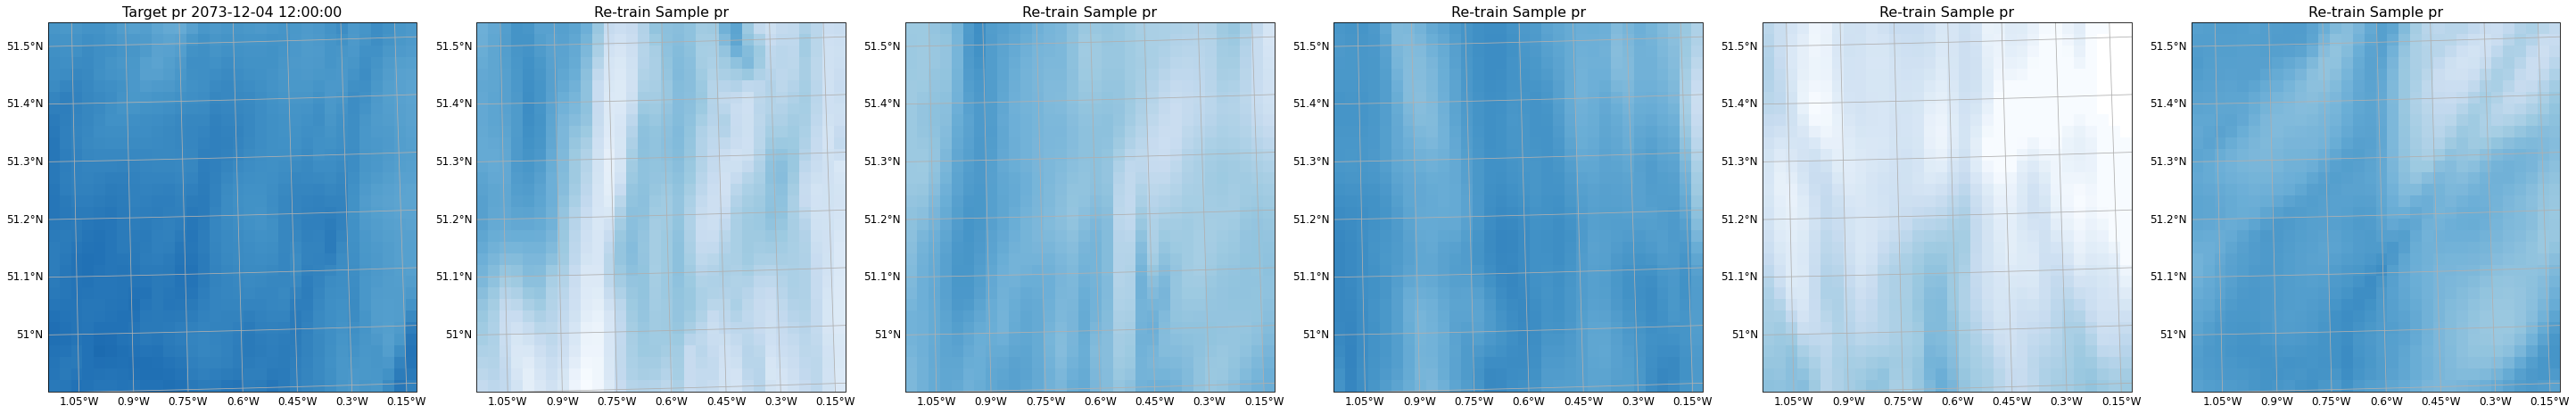

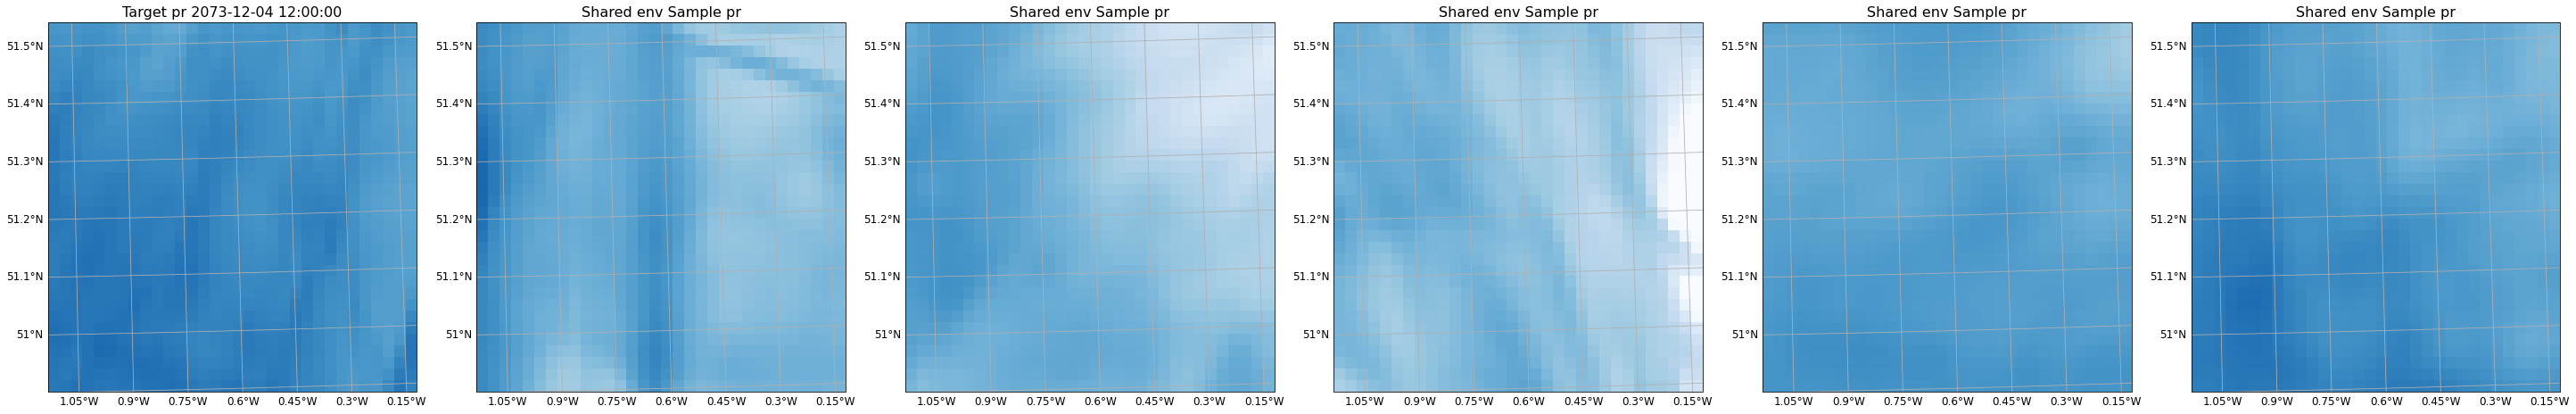

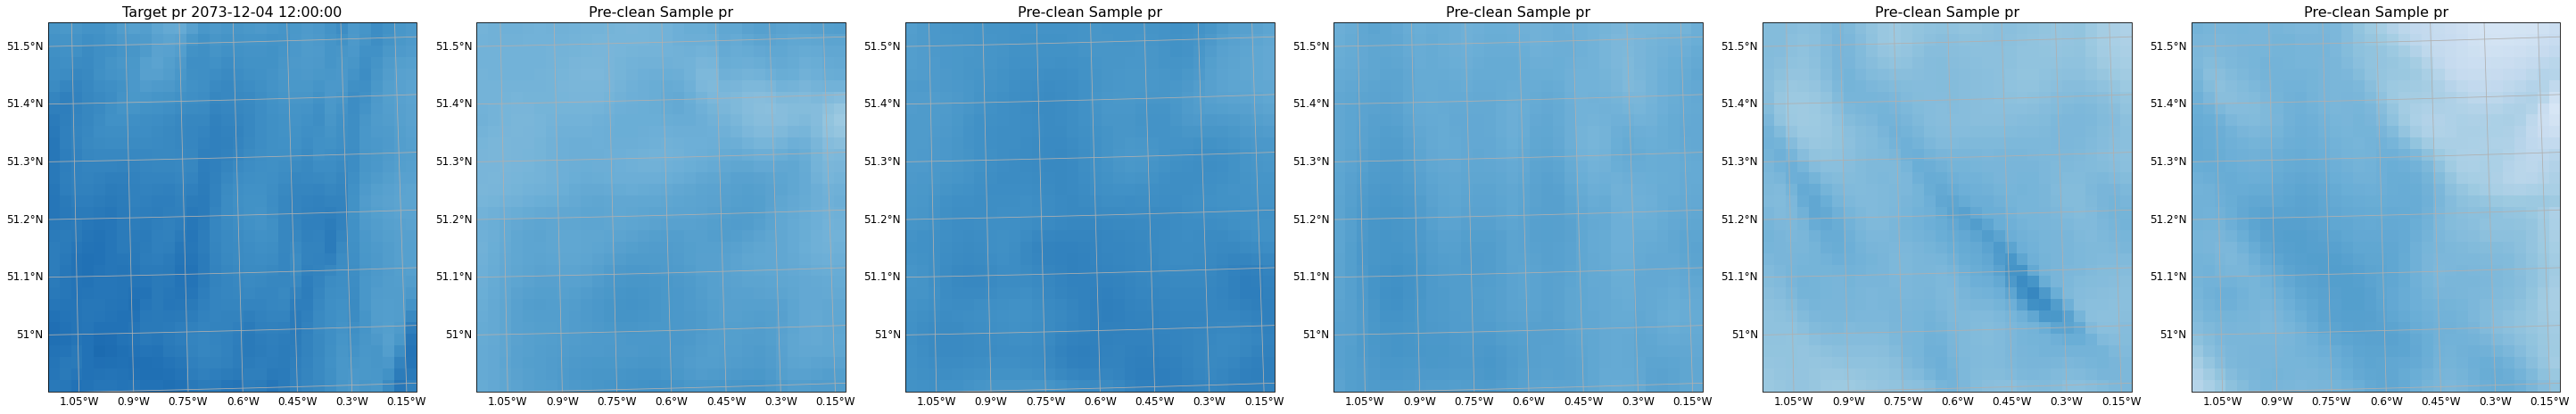

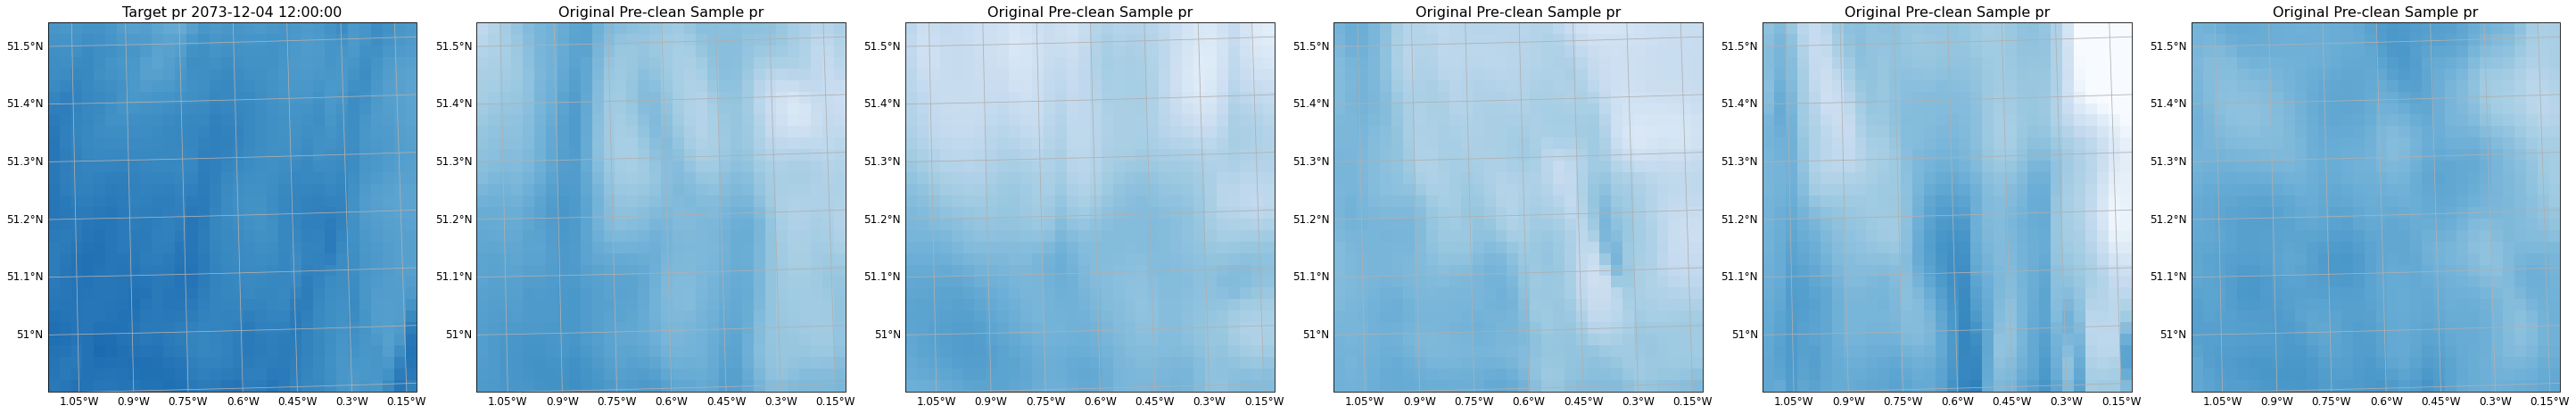

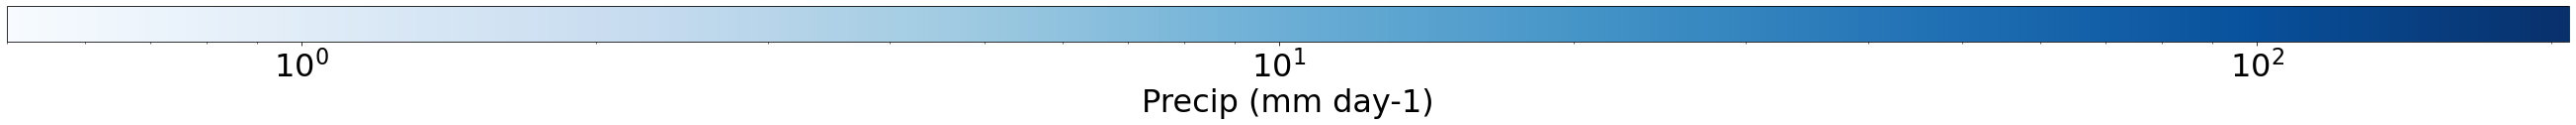

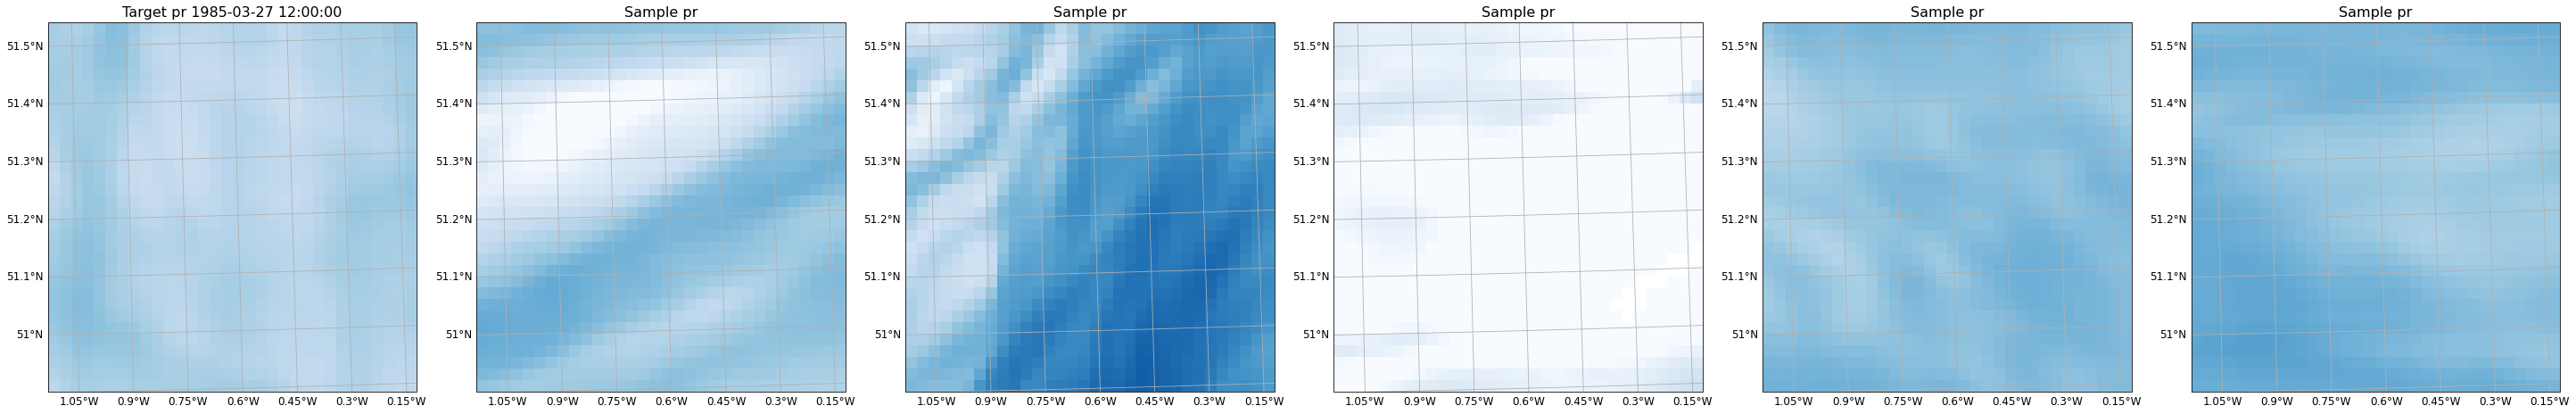

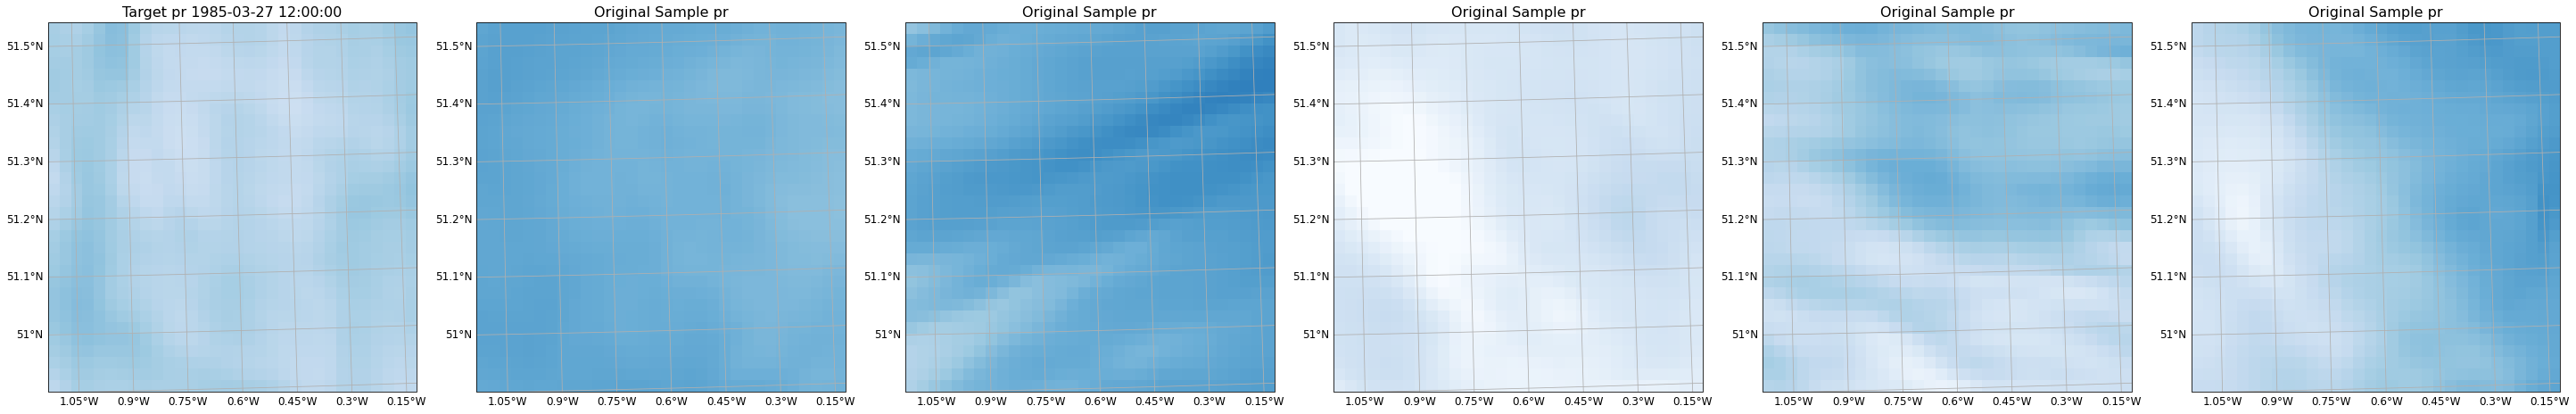

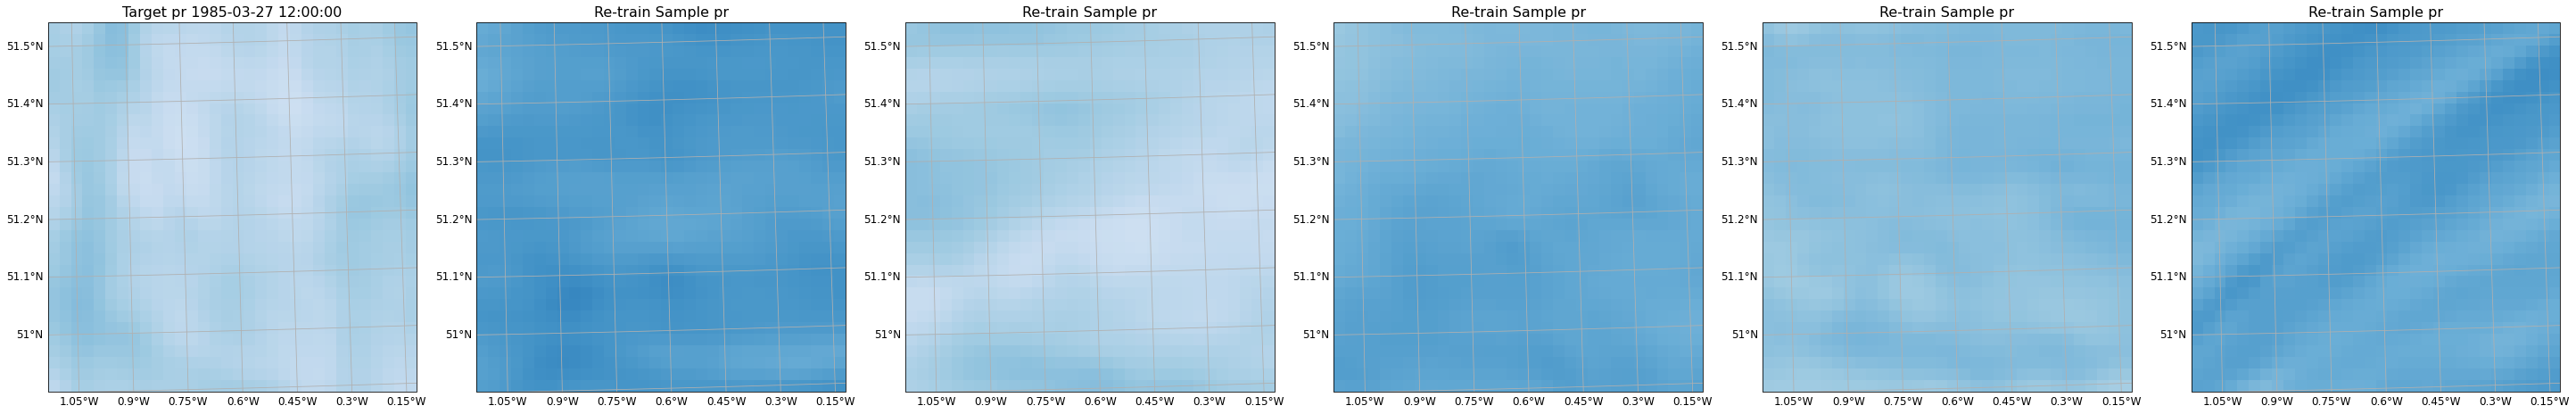

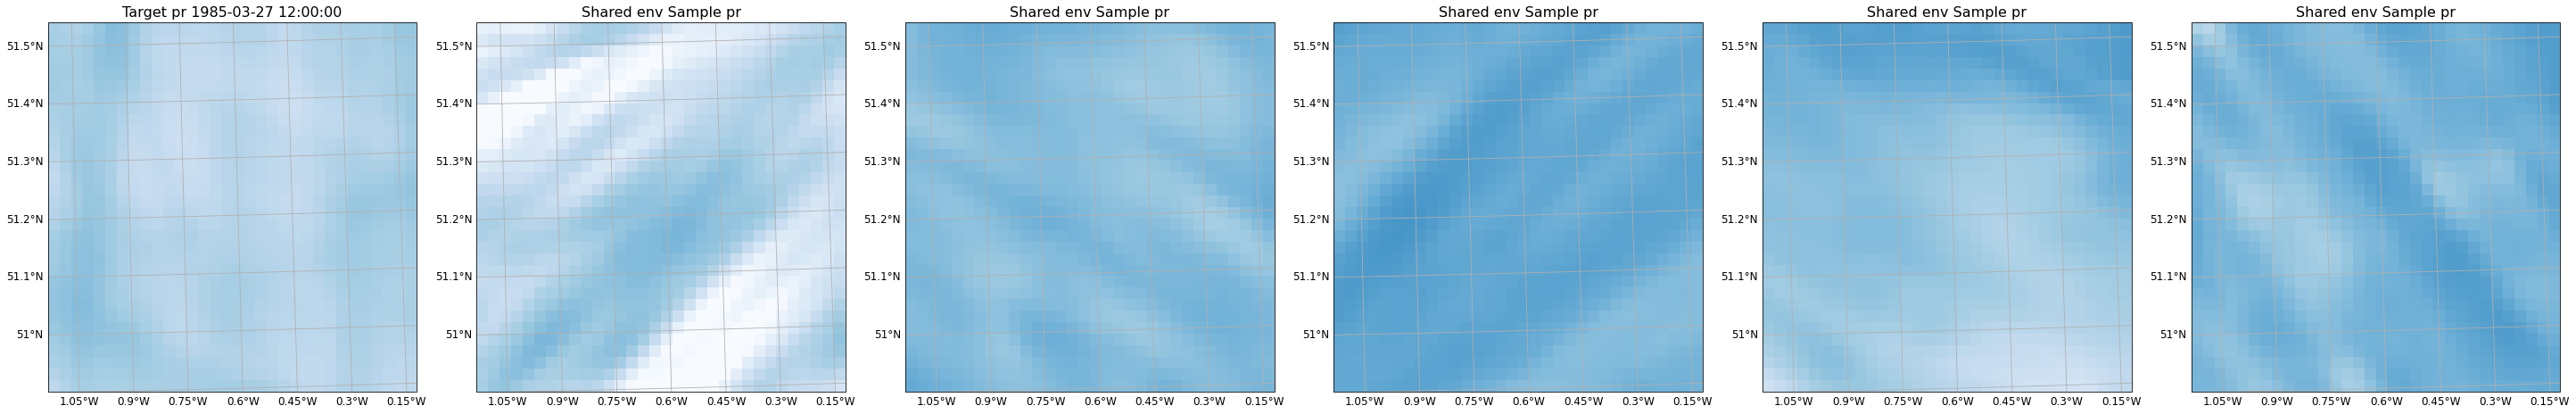

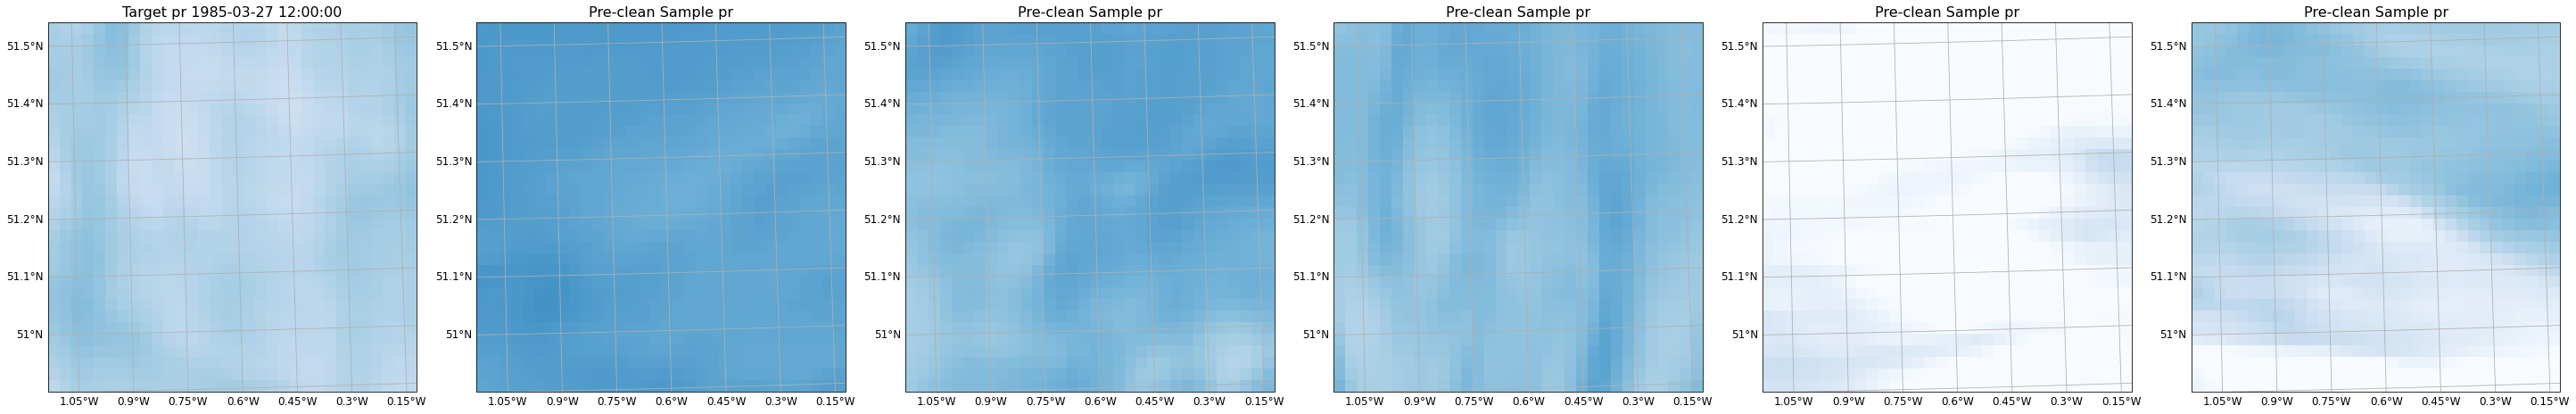

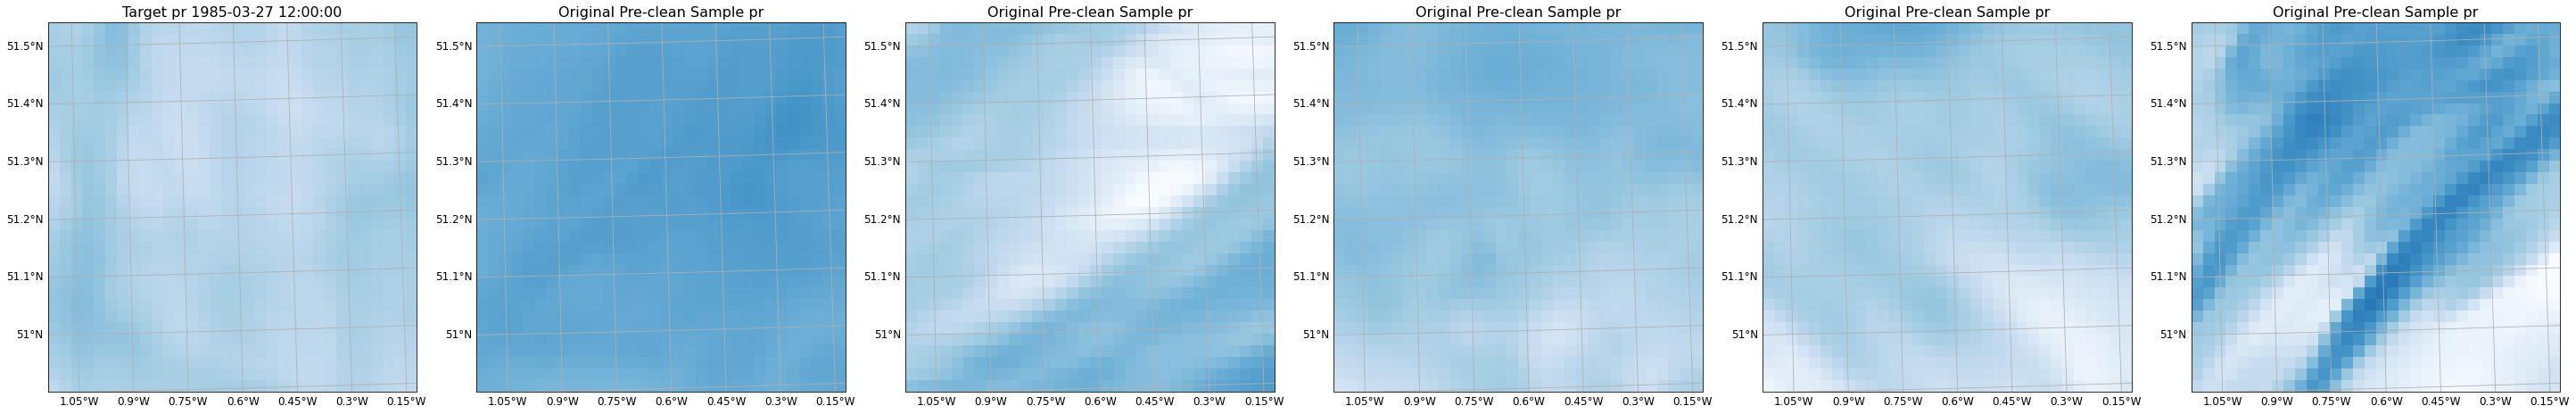

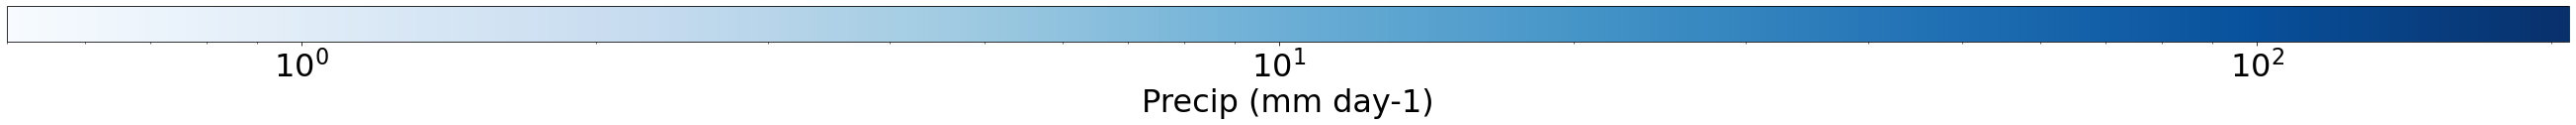

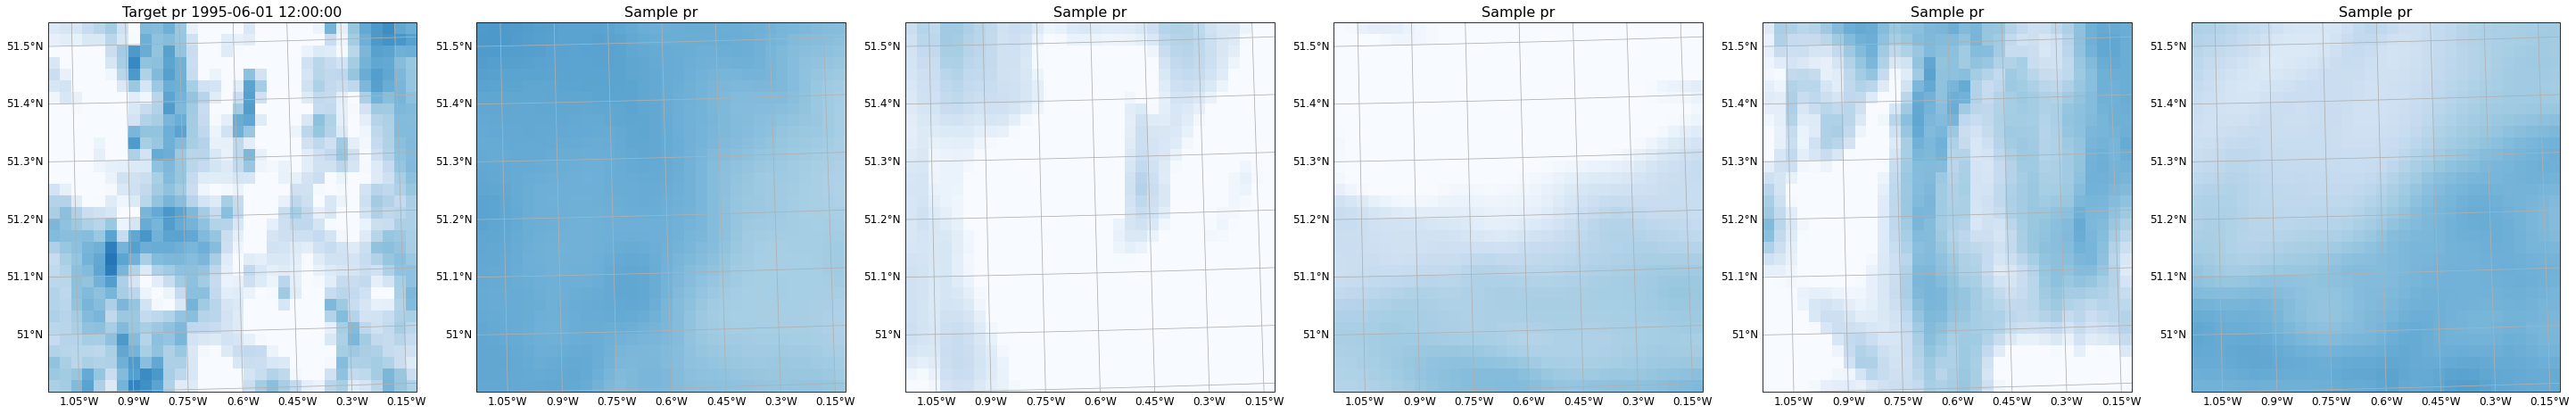

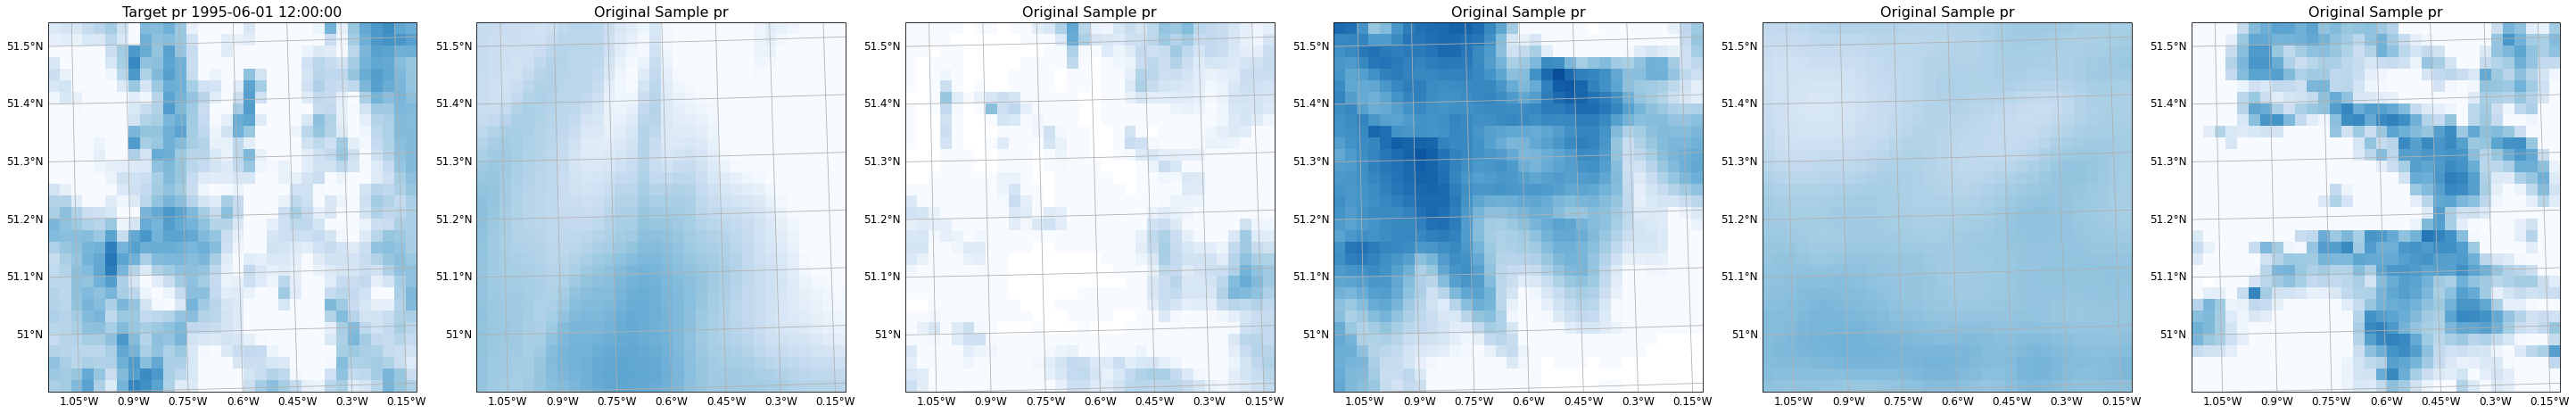

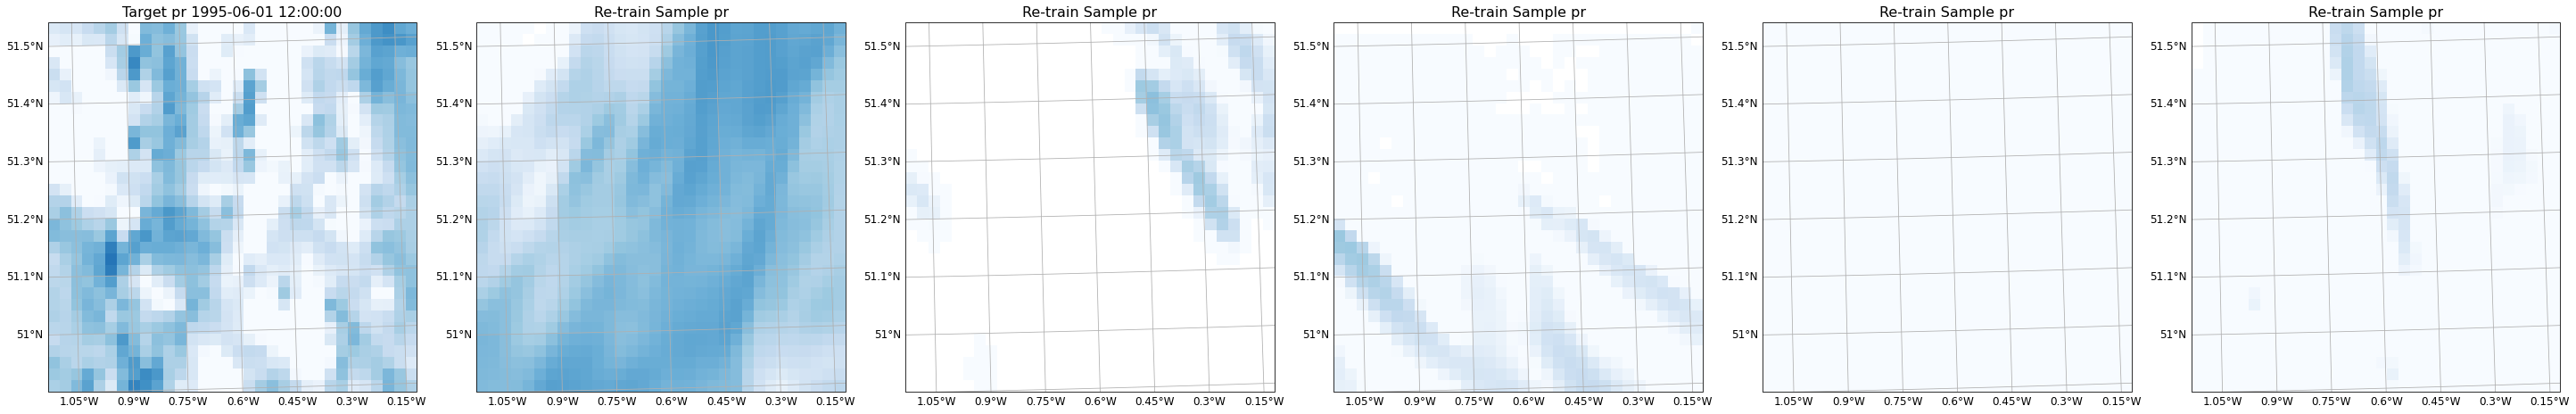

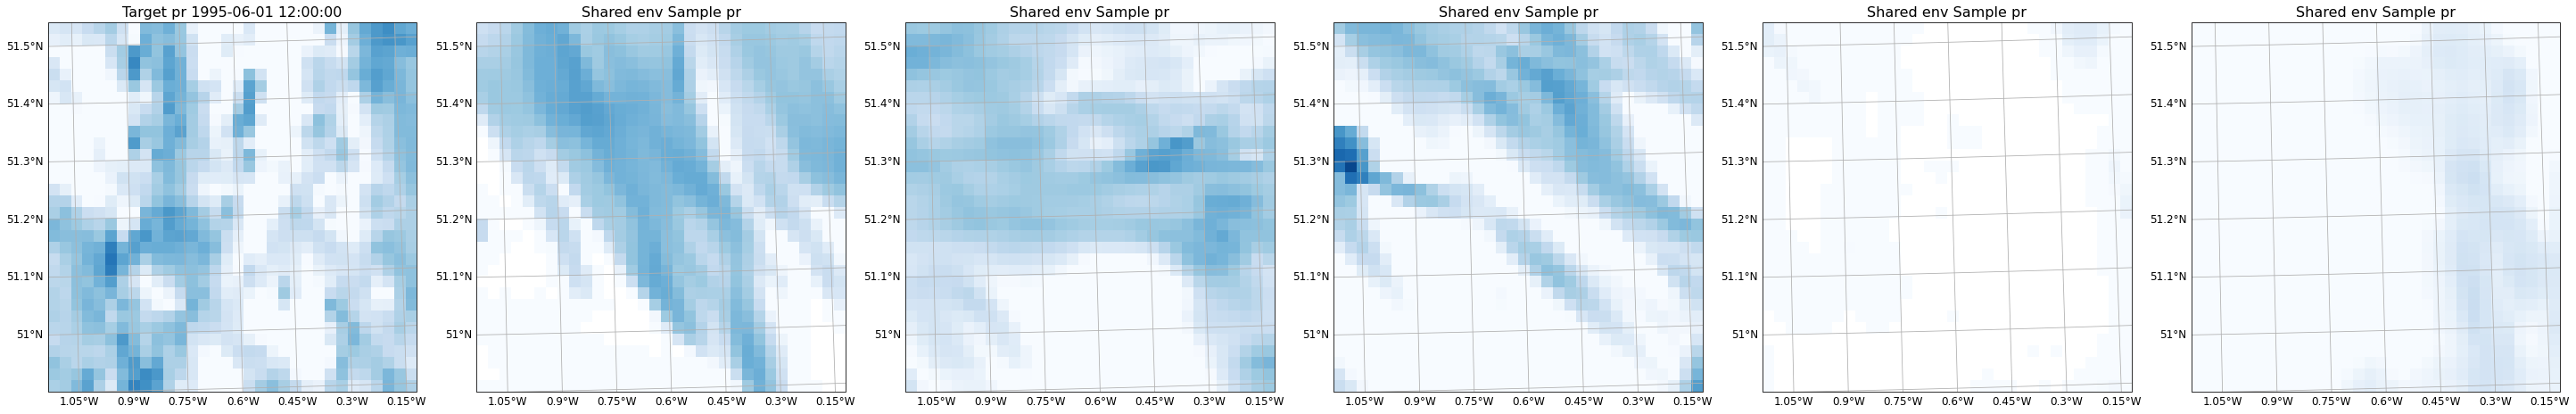

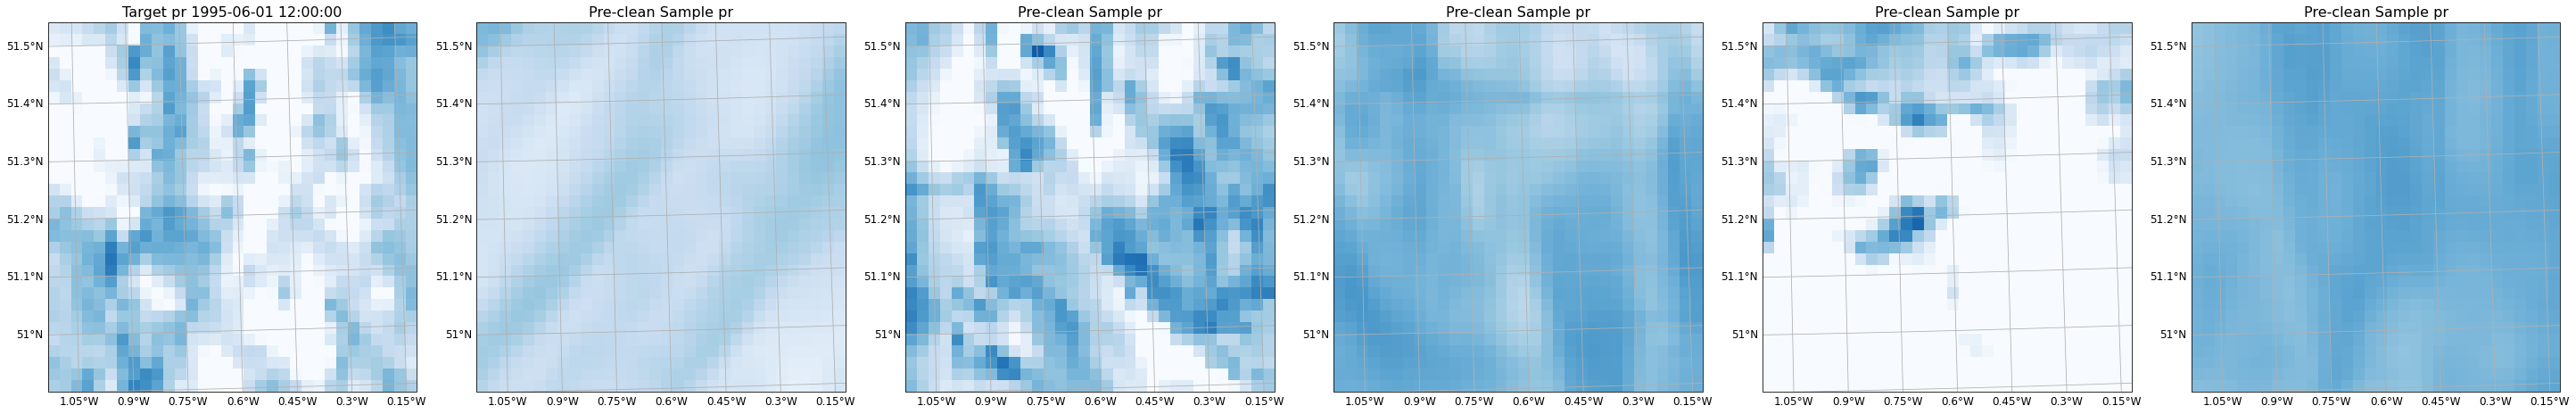

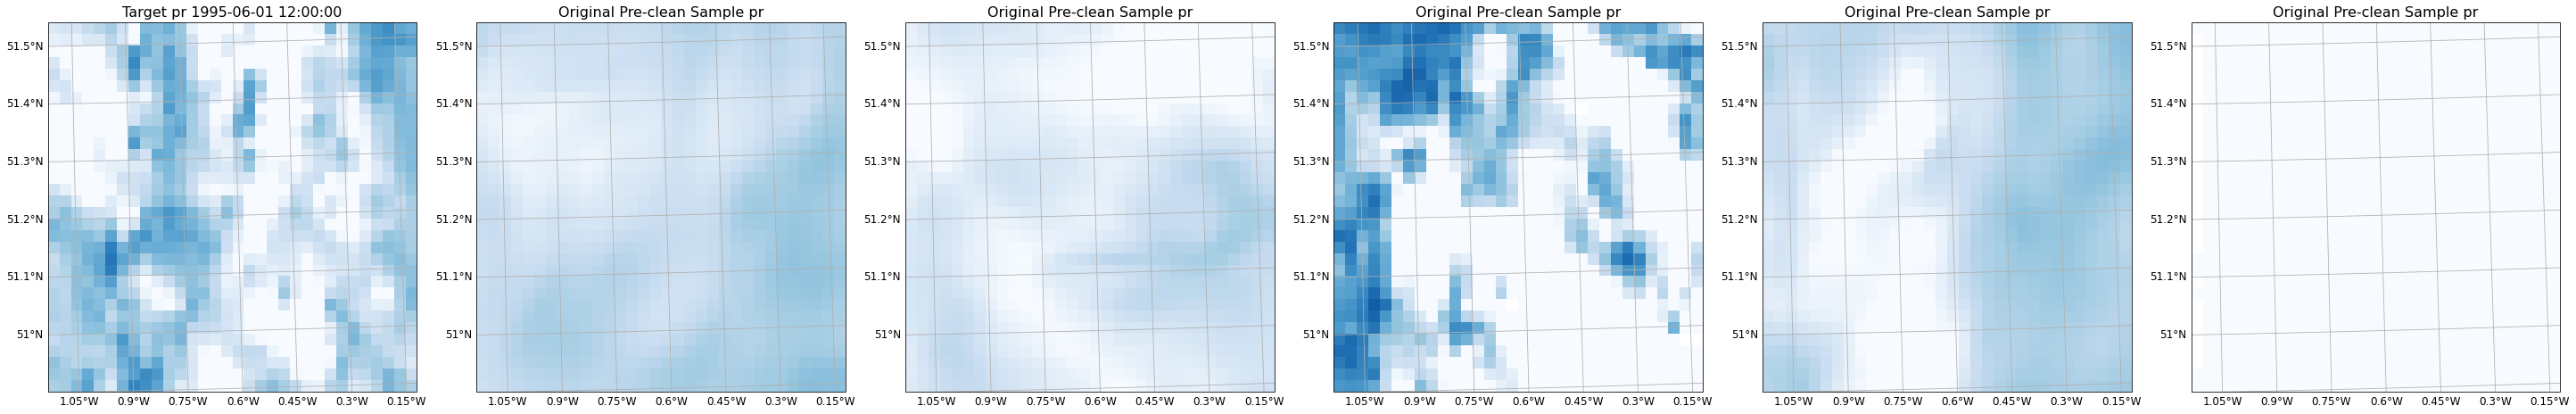

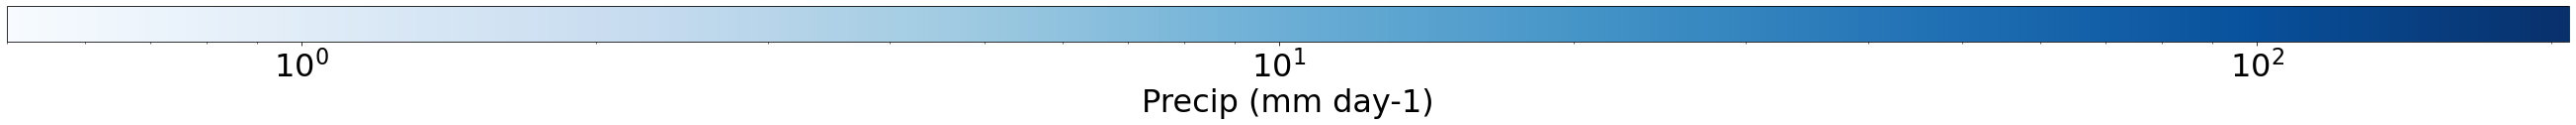

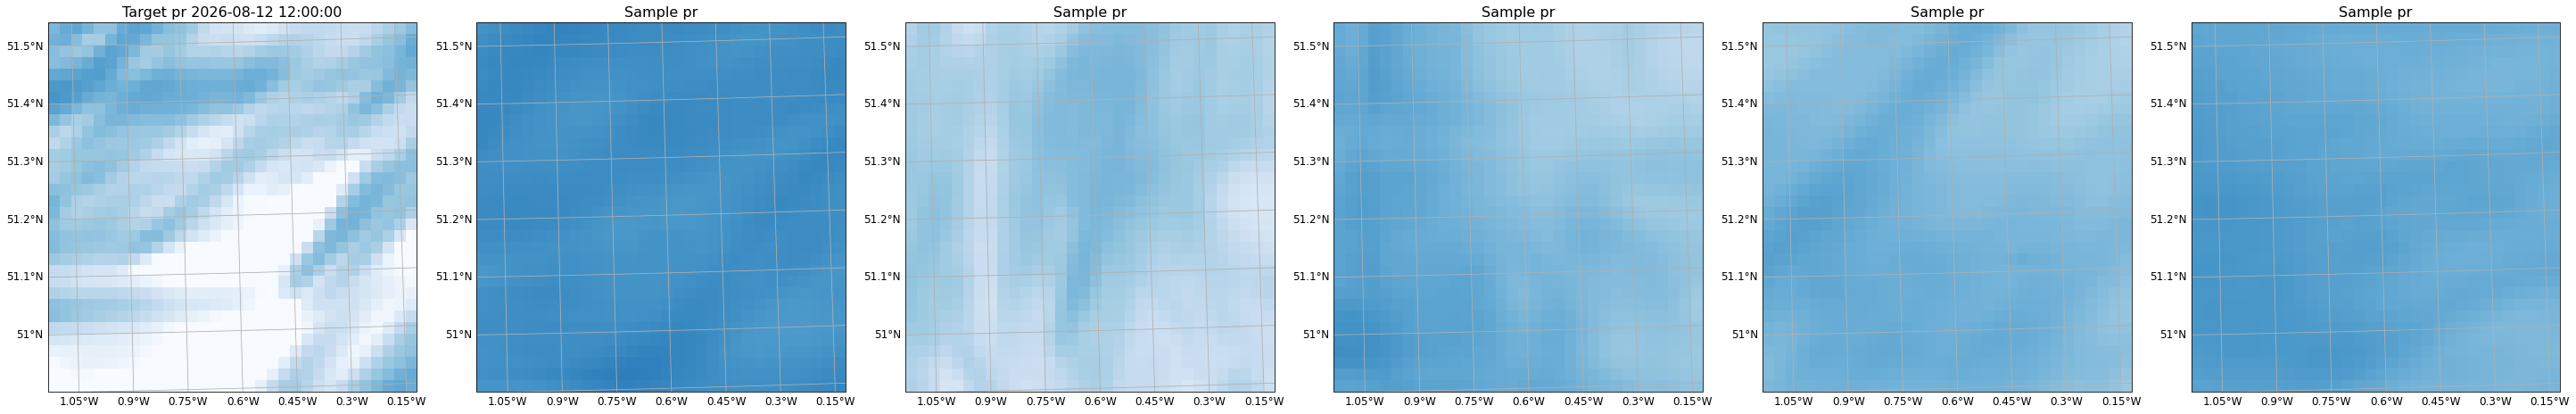

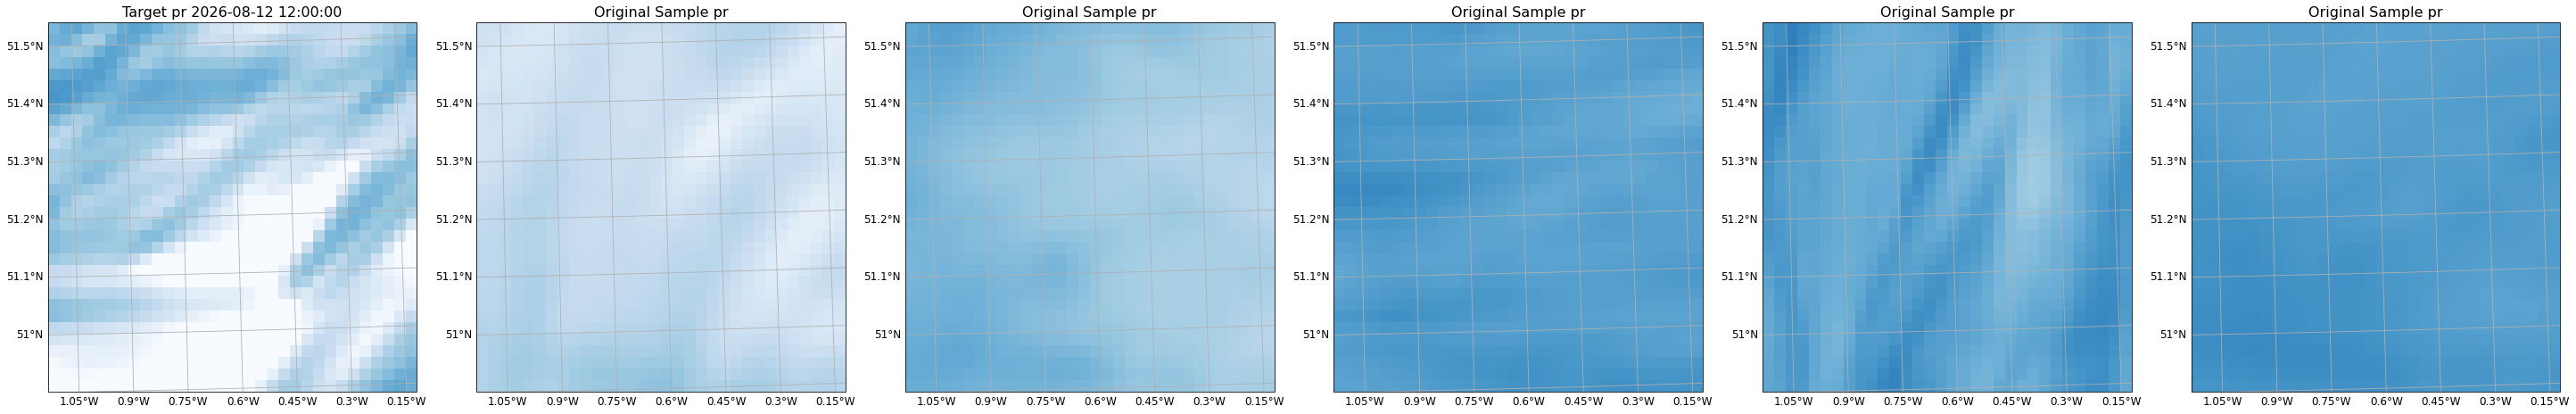

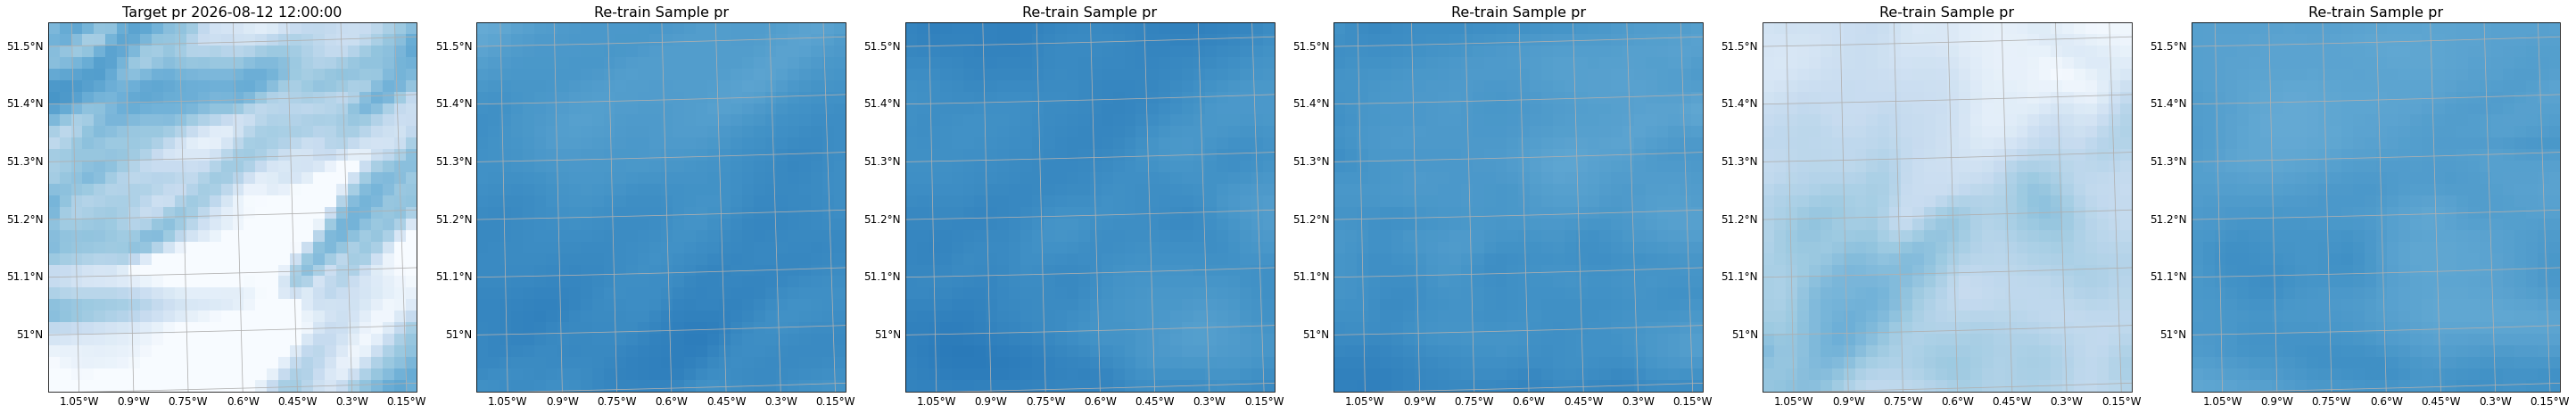

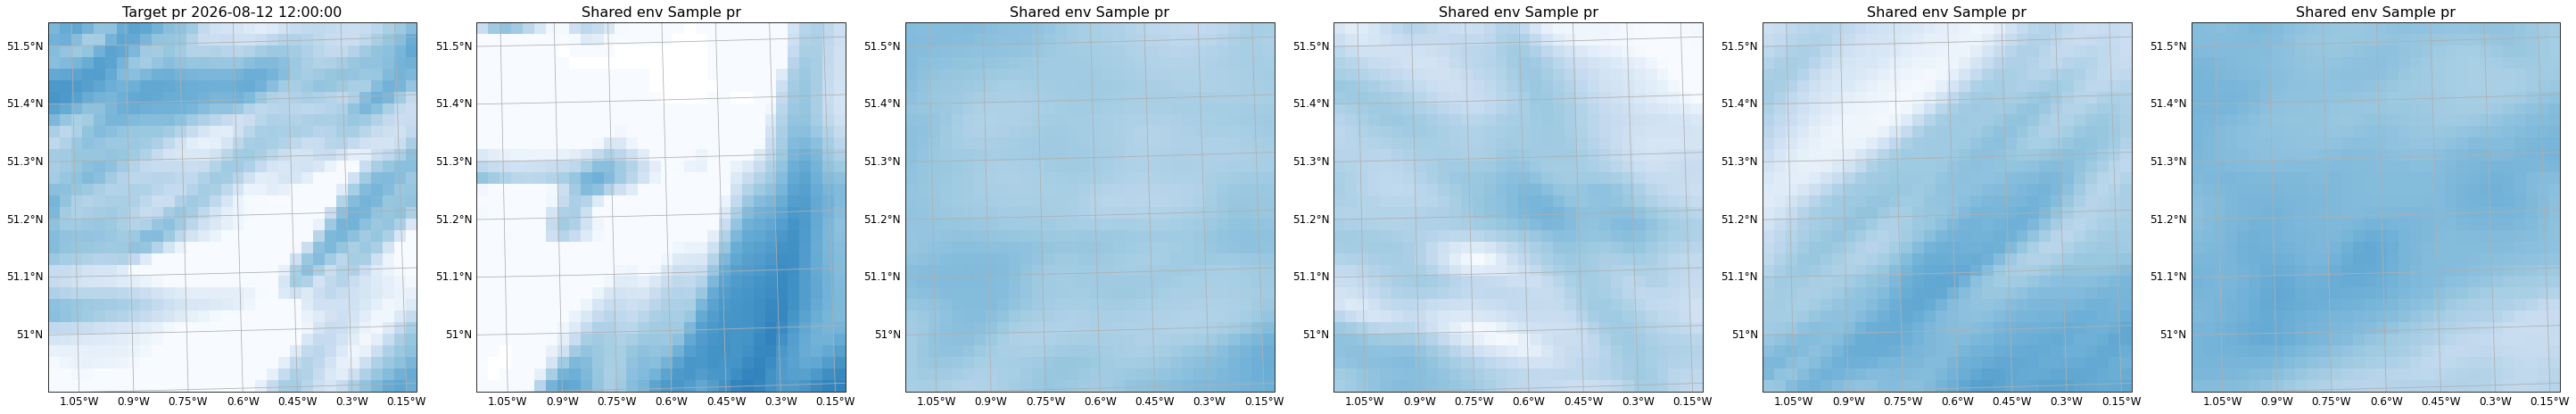

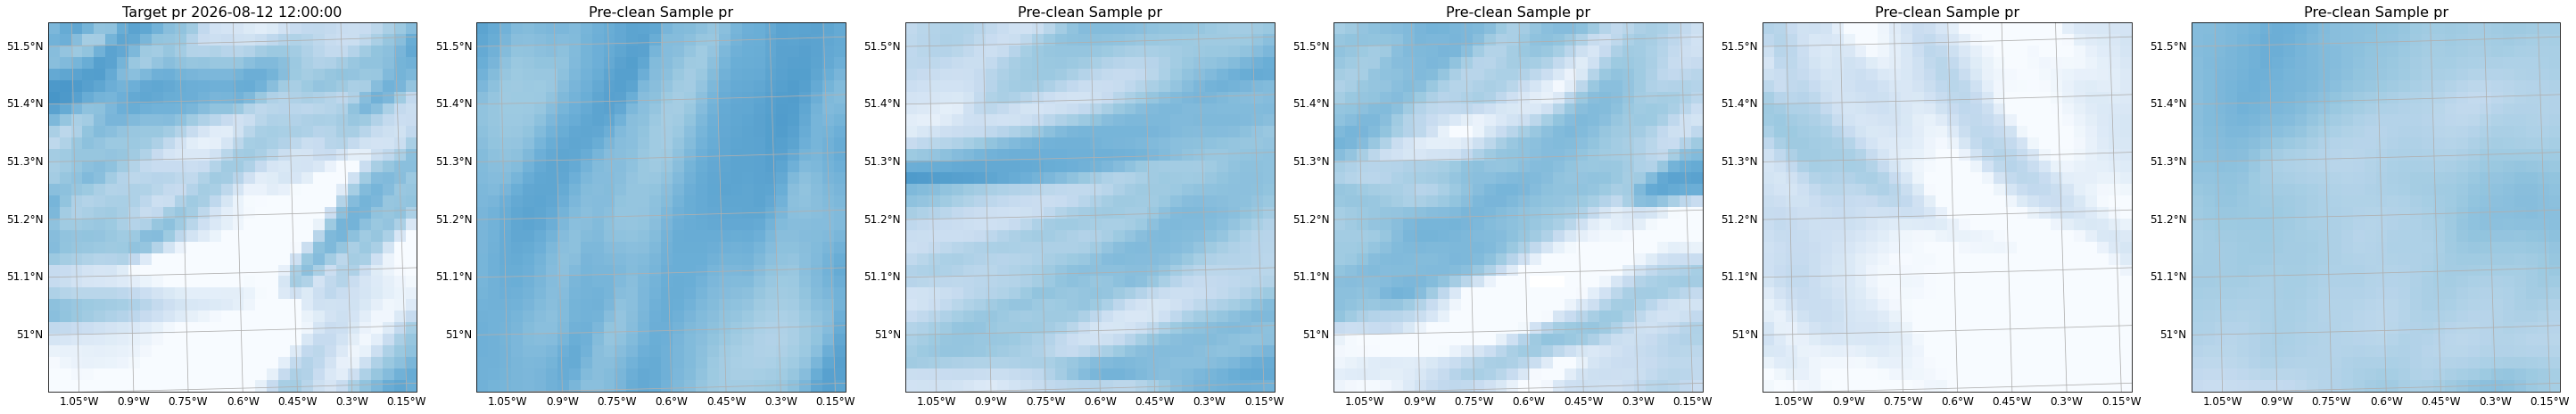

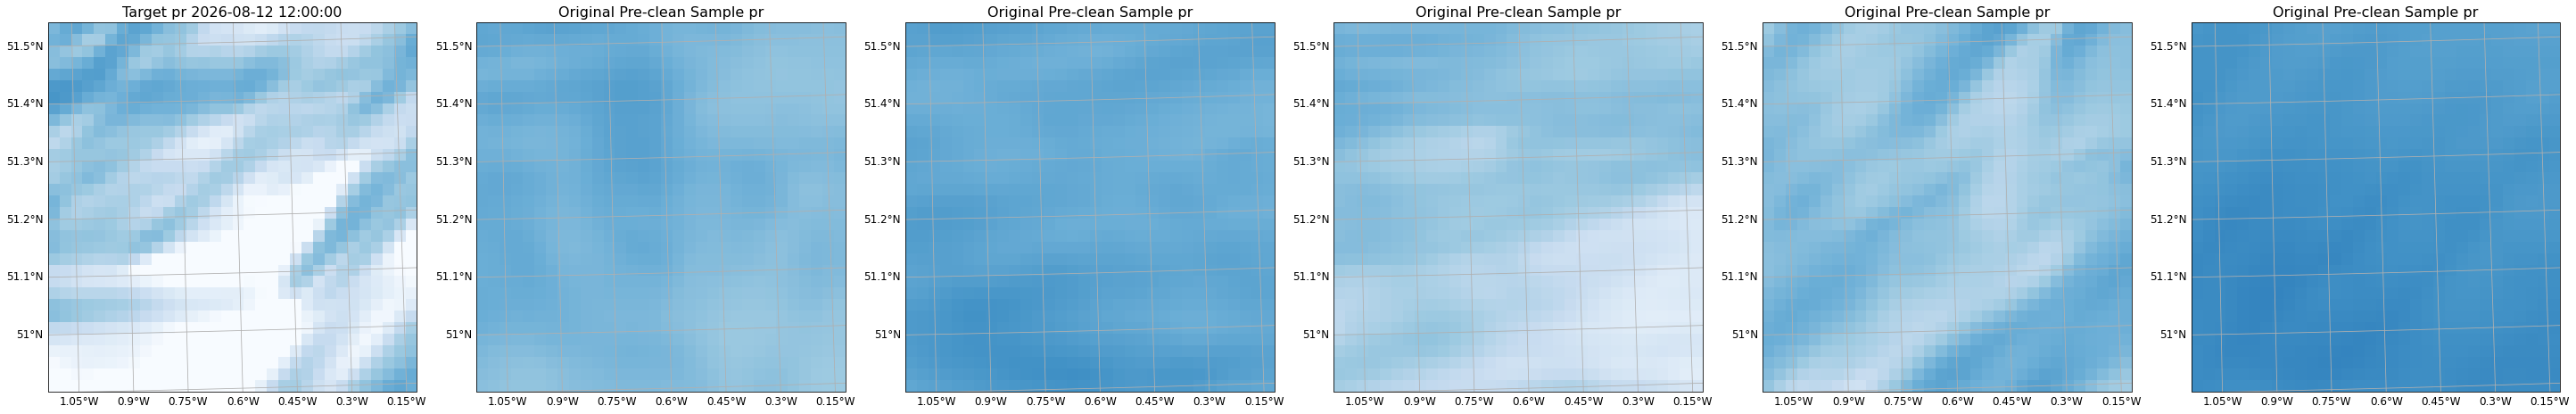

In [9]:
def show_predictions(ds, timestamps, vmin, vmax):
    num_predictions = 5#len(ds["sample_id"])
    
    num_plots_per_ts = num_predictions+1 # plot each sample and true target pr
    
    for (i, ts) in enumerate(timestamps):
        if i % 1 == 0:
            # s_m = matplotlib.cm.ScalarMappable(cmap="Blues", norm=matplotlib.colors.LogNorm(vmin=vmin, vmax=vmax))
            fig = plt.figure(figsize=(40, 5))
            ax = fig.add_axes([0.05, 0.80, 0.9, 0.1])
            cb = matplotlib.colorbar.ColorbarBase(ax, orientation='horizontal', cmap='Blues', norm=matplotlib.colors.LogNorm(vmin=vmin, vmax=vmax))
            ax.set_xlabel("Precip (mm day-1)", fontsize=32)
            ax.tick_params(axis='both', which='major', labelsize=32)
            plt.show()
        fig, axes = plt.subplots(1, num_plots_per_ts, figsize=(40,40), constrained_layout=True, subplot_kw={'projection': cp_model_rotated_pole})
        
        ax = axes[0]
        plot_grid(ds.sel(time=ts)["target_pr"], ax, title=f"Target pr {ts}", vmin=vmin, vmax=vmax, add_colorbar=False)
        
        for sample_id in range(num_predictions):
            ax = axes[1+sample_id]
            plot_grid(ds.sel(time=ts, sample_id=sample_id)["pred_pr"], ax, vmin=vmin, vmax=vmax, add_colorbar=False, title="Sample pr")            
        
        plt.show()
        
        fig, axes = plt.subplots(1, num_plots_per_ts, figsize=(40,40), constrained_layout=True, subplot_kw={'projection': cp_model_rotated_pole})
        
        ax = axes[0]
        plot_grid(ds.sel(time=ts)["target_pr"], ax, title=f"Target pr {ts}", vmin=vmin, vmax=vmax, add_colorbar=False)
        
        for sample_id in range(num_predictions):
            ax = axes[1+sample_id]
            plot_grid(orig_pred_ds.sel(time=ts, sample_id=sample_id)["pred_pr"], ax, vmin=vmin, vmax=vmax, add_colorbar=False, title="Original Sample pr")            
        
        plt.show()
        
        fig, axes = plt.subplots(1, num_plots_per_ts, figsize=(40,40), constrained_layout=True, subplot_kw={'projection': cp_model_rotated_pole})
        
        ax = axes[0]
        plot_grid(ds.sel(time=ts)["target_pr"], ax, title=f"Target pr {ts}", vmin=vmin, vmax=vmax, add_colorbar=False)
        
        for sample_id in range(num_predictions):
            ax = axes[1+sample_id]
            plot_grid(retrain_pred_ds.sel(time=ts, sample_id=sample_id)["pred_pr"], ax, vmin=vmin, vmax=vmax, add_colorbar=False, title="Re-train Sample pr")            
        
        plt.show()
        
        fig, axes = plt.subplots(1, num_plots_per_ts, figsize=(40,40), constrained_layout=True, subplot_kw={'projection': cp_model_rotated_pole})
        
        ax = axes[0]
        plot_grid(ds.sel(time=ts)["target_pr"], ax, title=f"Target pr {ts}", vmin=vmin, vmax=vmax, add_colorbar=False)
        
        for sample_id in range(num_predictions):
            ax = axes[1+sample_id]
            plot_grid(shared_env_pred_ds.sel(time=ts, sample_id=sample_id)["pred_pr"], ax, vmin=vmin, vmax=vmax, add_colorbar=False, title="Shared env Sample pr")            
        
        plt.show()
        
        fig, axes = plt.subplots(1, num_plots_per_ts, figsize=(40,40), constrained_layout=True, subplot_kw={'projection': cp_model_rotated_pole})
        
        ax = axes[0]
        plot_grid(ds.sel(time=ts)["target_pr"], ax, title=f"Target pr {ts}", vmin=vmin, vmax=vmax, add_colorbar=False)
        
        for sample_id in range(num_predictions):
            ax = axes[1+sample_id]
            plot_grid(preclean_pred_ds.sel(time=ts, sample_id=sample_id)["pred_pr"], ax, vmin=vmin, vmax=vmax, add_colorbar=False, title="Pre-clean Sample pr")            
        
        plt.show()
        
        fig, axes = plt.subplots(1, num_plots_per_ts, figsize=(40,40), constrained_layout=True, subplot_kw={'projection': cp_model_rotated_pole})
        
        ax = axes[0]
        plot_grid(ds.sel(time=ts)["target_pr"], ax, title=f"Target pr {ts}", vmin=vmin, vmax=vmax, add_colorbar=False)
        
        for sample_id in range(num_predictions):
            ax = axes[1+sample_id]
            plot_grid(orig_preclean_pred_ds.sel(time=ts, sample_id=sample_id)["pred_pr"], ax, vmin=vmin, vmax=vmax, add_colorbar=False, title="Original Pre-clean Sample pr")            
        
        plt.show()


timestamps = np.concatenate([
    sorted_time[t:t+3] for t in [
        -20, 
        # math.ceil(len(sorted_time)*0.9),
        math.ceil(len(sorted_time)*0.81),
        # math.ceil(len(sorted_time)*0.5), 
        # 17
    ]
])
# timestamps = np.random.choice(sorted_time, size=2*3, replace=False)
vmin = 0.5#1e-1*3600*24
vmax = max(merged_ds['pred_pr'].max().values, merged_ds['target_pr'].max().values)
        
show_predictions(merged_ds, timestamps, vmin, vmax)

In [10]:
def distribution_figure(target_pr, pred_pr, target_quantiles, pred_quantiles, tail_thr, extreme_thr, figtitle):
    fig, axes = plt.subplot_mosaic([
        ["Density"], 
        ["Quantiles"], 
    ], figsize=(20, 20), constrained_layout=True)

    ax = axes["Density"]
    _, bins, _ = pred_pr.plot.hist(ax=ax, bins=50, density=True,alpha=0.75, label="Samples", log=True)
    target_pr.plot.hist(ax=ax, bins=bins, density=True,alpha=1, color="black", histtype="step", label="Target", log=True, linewidth=3, linestyle="-")
    orig_pred_ds["pred_pr"].plot.hist(ax=ax, bins=bins, density=True, histtype="step", alpha=0.5, label="Original samples", log=True, linewidth=3)
    preclean_pred_ds["pred_pr"].plot.hist(ax=ax, bins=bins, density=True, histtype="step", alpha=0.5, label="Pre-clean samples", log=True, linewidth=3)
    orig_preclean_pred_ds["pred_pr"].plot.hist(ax=ax, bins=bins, density=True, histtype="step", alpha=0.5, label="Original pre-clean samples", log=True, linewidth=3)
    retrain_pred_ds["pred_pr"].plot.hist(ax=ax, bins=bins, density=True, histtype="step", alpha=0.5, label="Re-train samples", log=True, linewidth=3)
    shared_env_pred_ds["pred_pr"].plot.hist(ax=ax, bins=bins, density=True, histtype="step", alpha=0.5, label="Shared env samples", log=True, linewidth=3)
    
    ax.set_title("Log density plot of samples and target precipitation", fontsize=24)
    ax.set_xlabel("Precip (mm day-1)", fontsize=16)
    ax.tick_params(axis='both', which='major', labelsize=16)
    text = f"""
    # Timestamps: {pred_pr["time"].count().values}
    # Samples: {pred_pr.count().values}
    # Targets: {target_pr.count().values}
    % Samples == 0: {(((pred_pr == 0).sum()/pred_pr.count()).values*100).round()}
    % Targets == 0: {(((target_pr == 0).sum()/target_pr.count()).values*100).round()}
    % Samples < 0.1: {(((pred_pr < 0.1).sum()/pred_pr.count()).values*100).round()}
    % Targets < 0.1: {(((target_pr < 0.1).sum()/target_pr.count()).values*100).round()}
    Sample max: {pred_pr.max().values.round()}
    Orig Sample max: {orig_pred_ds["pred_pr"].max().values.round()}
    Pre-clean Sample max: {preclean_pred_ds["pred_pr"].max().values.round()}
    Orig Pre-clean Sample max: {orig_preclean_pred_ds["pred_pr"].max().values.round()}
    Re-train Sample max: {retrain_pred_ds["pred_pr"].max().values.round()}
    Shared env Sample max: {shared_env_pred_ds["pred_pr"].max().values.round()}
    Target max: {target_pr.max().values.round()}
    """
    ax.text(0.7, 0.5, text, fontsize=16, transform=ax.transAxes)
    ax.legend(fontsize=16)

    ax = axes["Quantiles"]
    ideal_tr = max(np.max(target_quantiles), np.max(pred_quantiles))
    ax.scatter(target_quantiles, pred_quantiles, label="Samples")
    ax.scatter(target_quantiles, orig_pred_quantiles, label="Original")
    ax.scatter(target_quantiles, preclean_pred_quantiles, label="Preclean")
    ax.scatter(target_quantiles, orig_preclean_pred_quantiles, label="Original Preclean")
    ax.scatter(target_quantiles, retrain_pred_quantiles, label="Retrain")
    ax.scatter(target_quantiles, shared_env_pred_quantiles, label="Shared Env")
    ax.plot([0,ideal_tr], [0,ideal_tr], color="orange", linestyle="--", label="Ideal")
    ax.set_xlabel("Target pr (mm day-1)", fontsize=16)
    ax.set_ylabel("Sample pr (mm day-1", fontsize=16)
    ax.set_title("Sample quantiles vs Target quantiles (90th to 99.9th centiles)", fontsize=16)
    text = f"""
    
    """
    ax.text(0.75, 0.2, text, fontsize=16, transform=ax.transAxes)
    ax.legend()
    ax.set_aspect(aspect=1)

    fig.suptitle(figtitle, fontsize=32)
    
    plt.show()

### Pixel

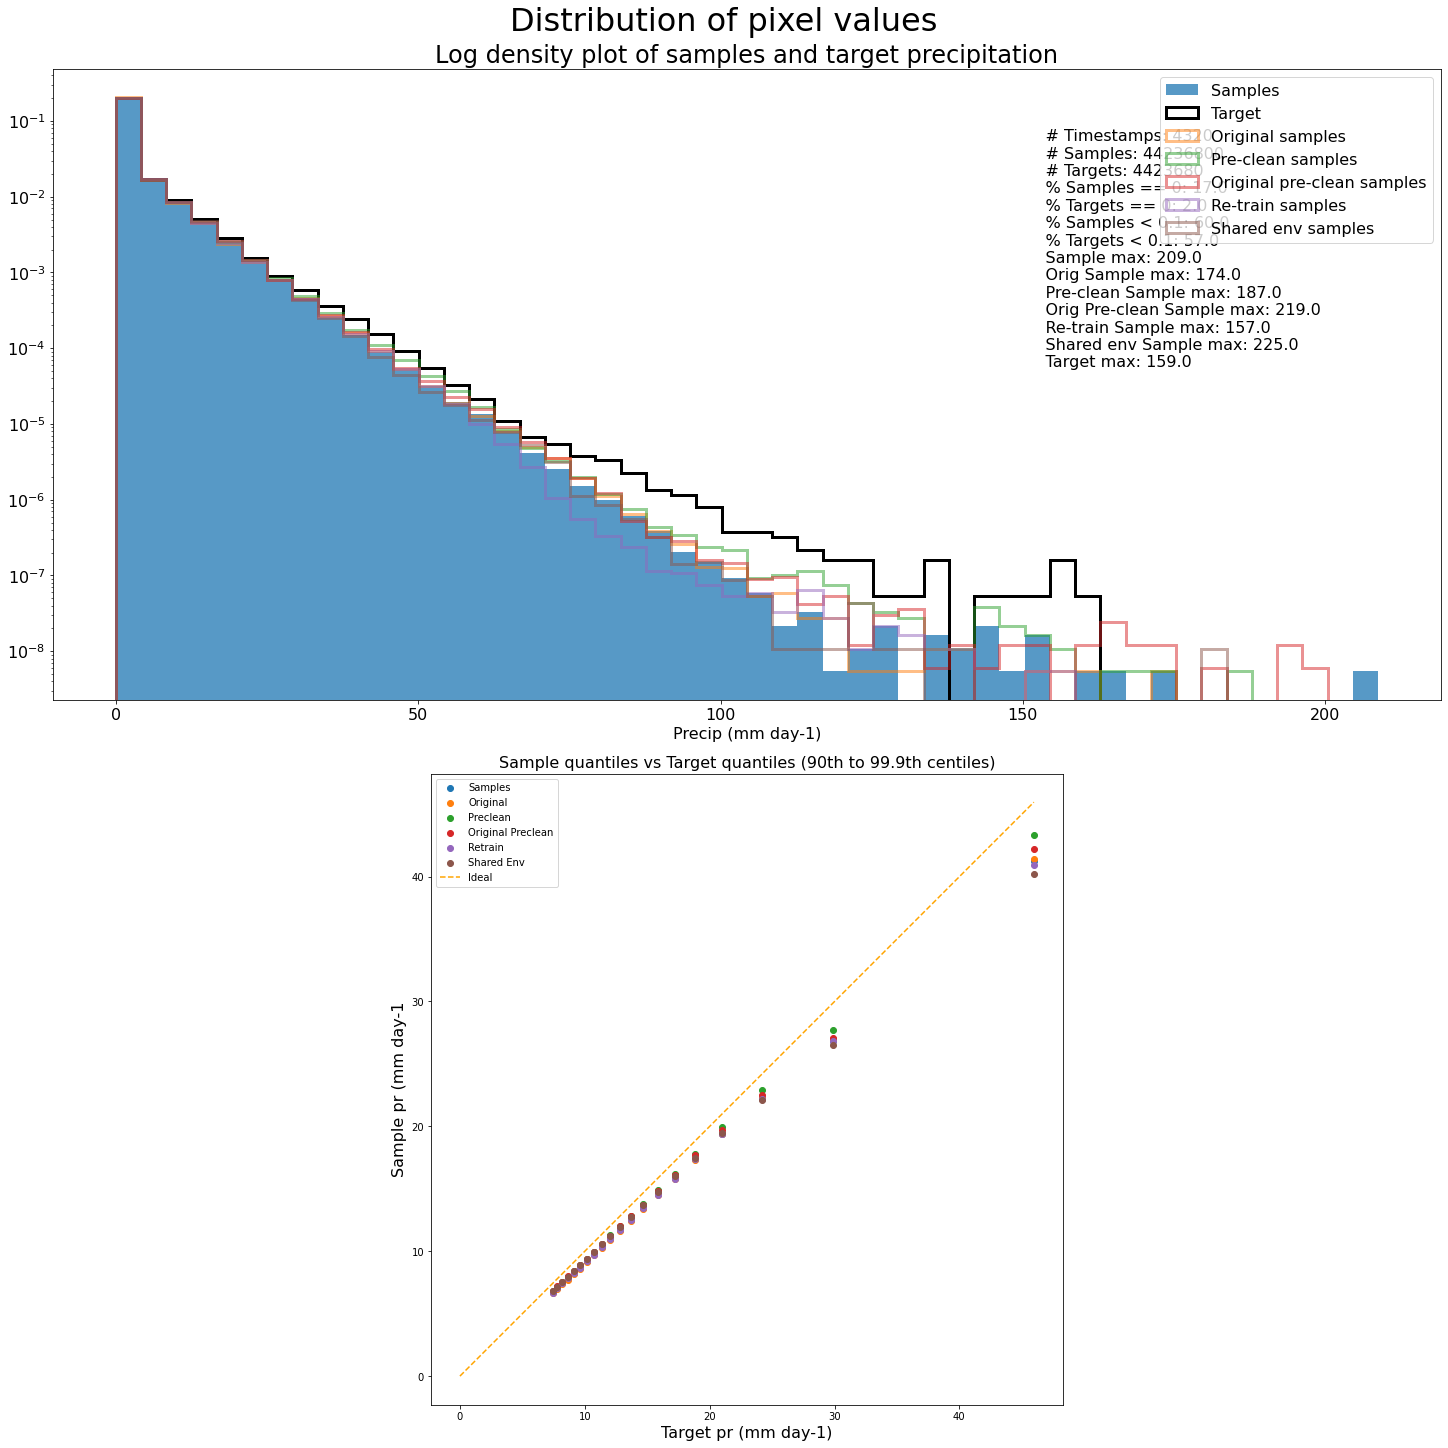

In [11]:
quantiles = np.linspace(0.9,0.999,20)
target_quantiles = target_pr.quantile(quantiles)
pred_quantiles = pred_pr.chunk(dict(sample_id=-1)).quantile(quantiles)
orig_pred_quantiles = orig_pred_ds["pred_pr"].chunk(dict(sample_id=-1)).quantile(quantiles)
preclean_pred_quantiles = preclean_pred_ds["pred_pr"].chunk(dict(sample_id=-1)).quantile(quantiles)
orig_preclean_pred_quantiles = orig_preclean_pred_ds["pred_pr"].chunk(dict(sample_id=-1)).quantile(quantiles)
retrain_pred_quantiles = retrain_pred_ds["pred_pr"].chunk(dict(sample_id=-1)).quantile(quantiles)
shared_env_pred_quantiles = shared_env_pred_ds["pred_pr"].chunk(dict(sample_id=-1)).quantile(quantiles)
# distribution_figure(target_pr, pred_pr, target_quantiles, pred_quantiles, 40, 80, "Distribution of pixel values")
distribution_figure(target_pr, pred_pr, target_quantiles, pred_quantiles, pred_pr.chunk(dict(sample_id=-1)).quantile(0.9999), pred_pr.chunk(dict(sample_id=-1)).quantile(0.99999), "Distribution of pixel values")

## Means

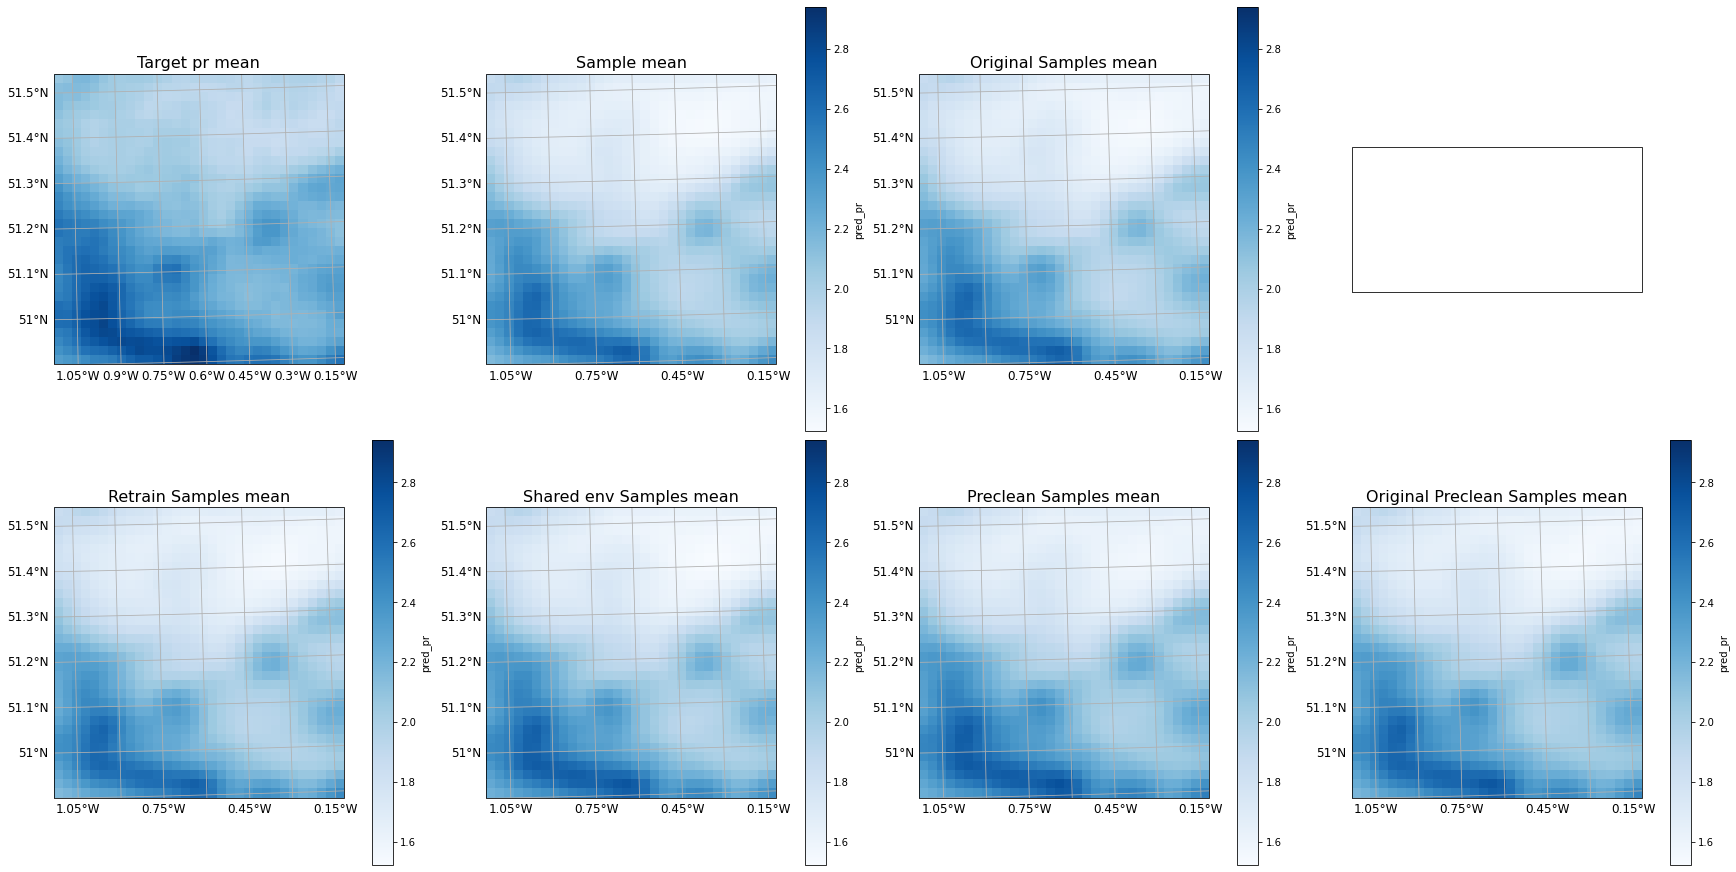

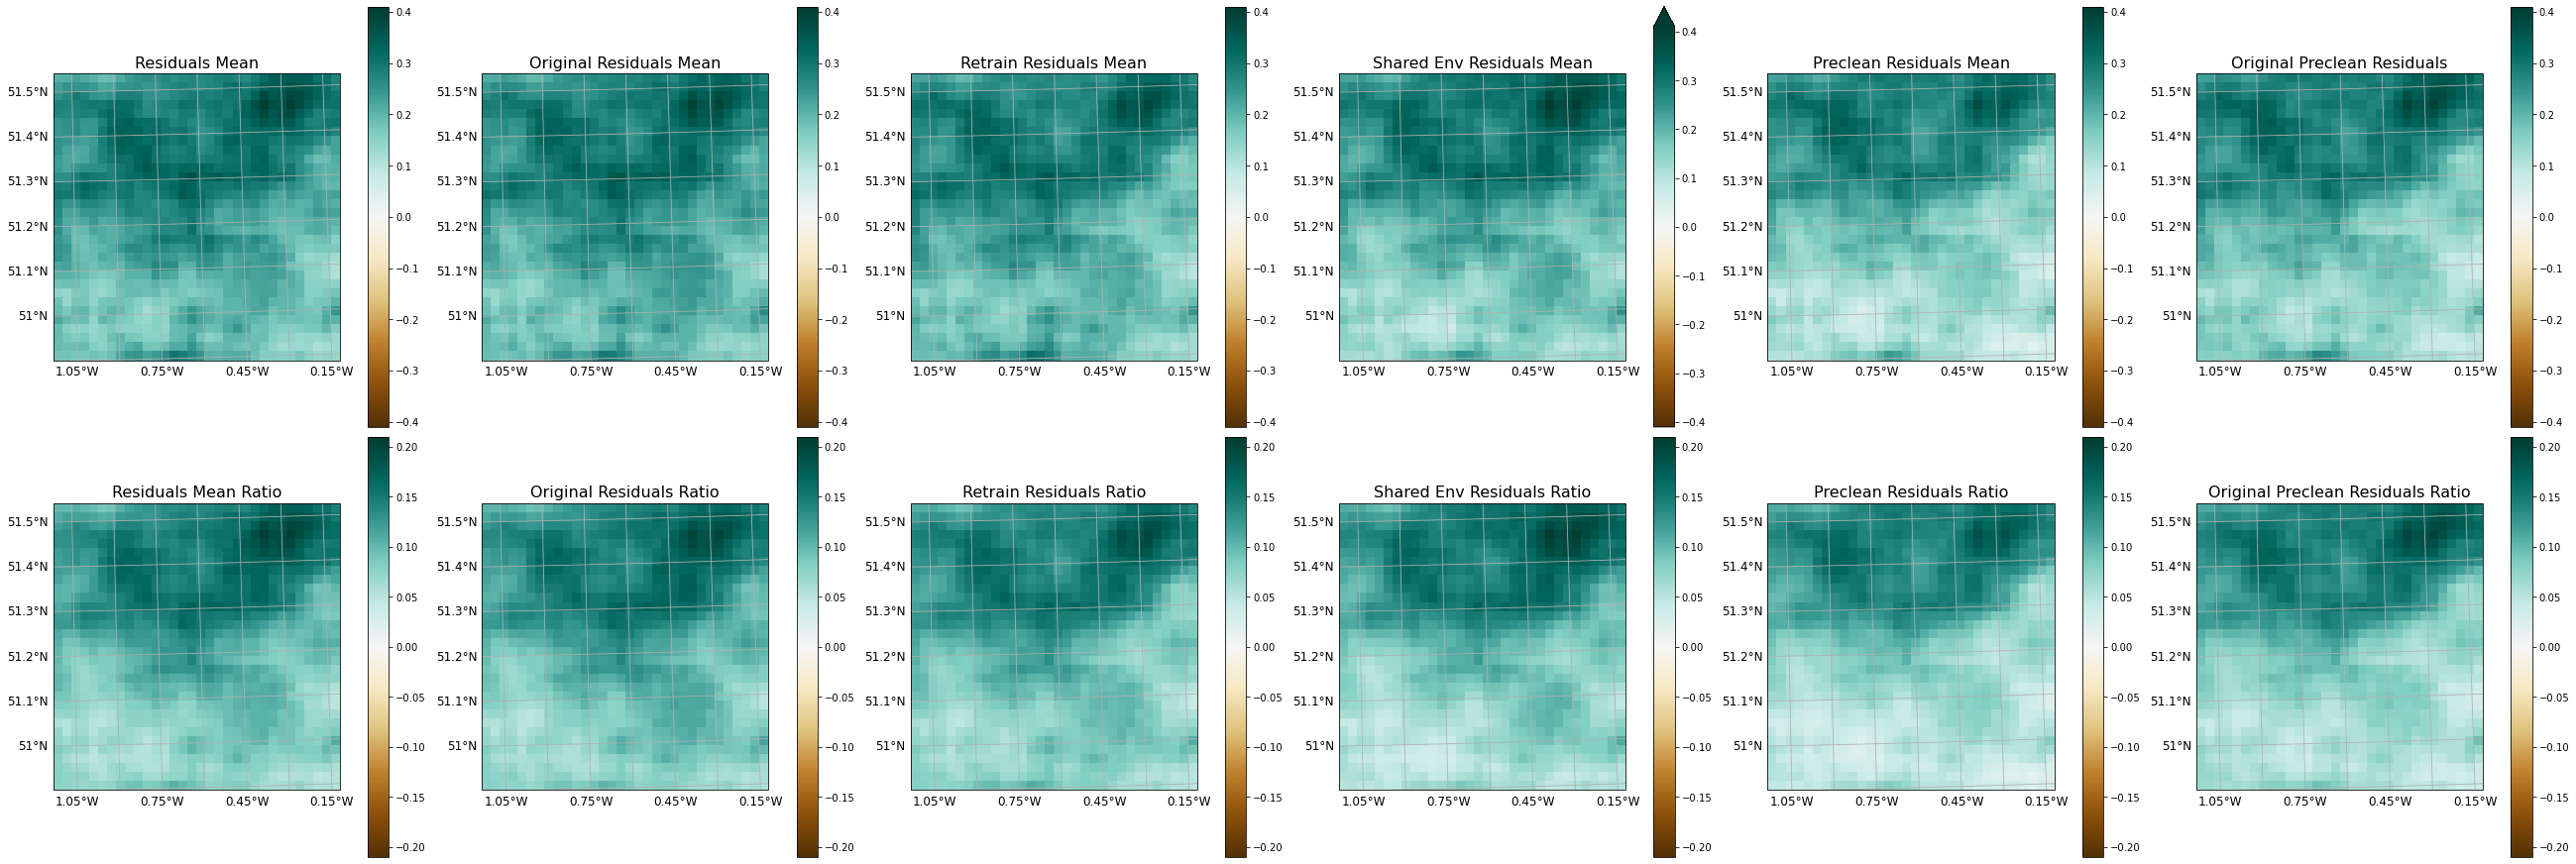

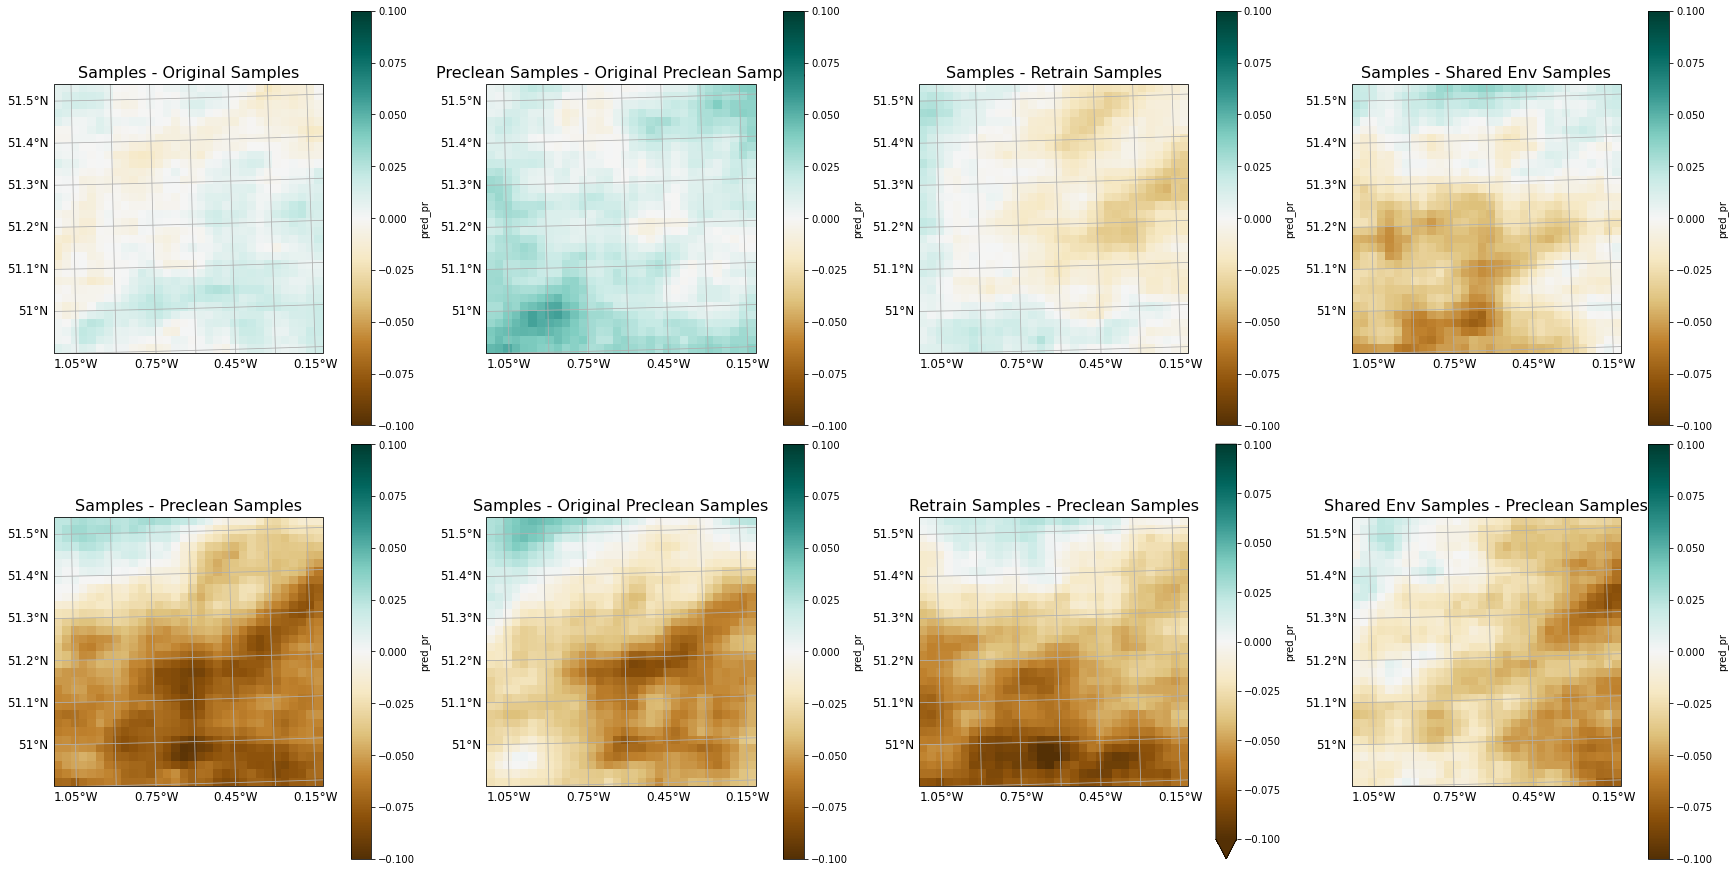

In [15]:
target_mean = merged_ds['target_pr'].mean(dim="time")
sample_mean = merged_ds['pred_pr'].mean(dim=["sample_id", "time"])
orig_sample_mean = orig_pred_ds['pred_pr'].mean(dim=["sample_id", "time"])
preclean_sample_mean = preclean_pred_ds['pred_pr'].mean(dim=["sample_id", "time"])
orig_preclean_sample_mean = orig_preclean_pred_ds['pred_pr'].mean(dim=["sample_id", "time"])
retrain_sample_mean = retrain_pred_ds['pred_pr'].mean(dim=["sample_id", "time"])
shared_env_sample_mean = shared_env_pred_ds['pred_pr'].mean(dim=["sample_id", "time"])

vmin = min([da.min().values for da in [orig_preclean_sample_mean, preclean_sample_mean, orig_sample_mean, sample_mean, target_mean, shared_env_sample_mean]])
vmax = max([da.max().values for da in [orig_preclean_sample_mean, preclean_sample_mean, orig_sample_mean, sample_mean, target_mean, shared_env_sample_mean]])

fig, axd = plt.subplot_mosaic([["Target", "Samples", "Original Samples", None], ["Retrain Samples", "Shared env Samples", "Preclean Samples", "Original Preclean Samples"]], figsize=(24, 12), subplot_kw=dict(projection=cp_model_rotated_pole), constrained_layout=True)

ax = axd["Target"]
plot_grid(target_mean, ax, title="Target pr mean", norm=matplotlib.colors.Normalize(vmin=vmin, vmax=vmax), add_colorbar=False)

ax = axd["Samples"]
plot_grid(sample_mean, ax, title="Sample mean", norm=matplotlib.colors.Normalize(vmin=vmin, vmax=vmax), add_colorbar=True)

ax = axd["Original Samples"]
plot_grid(orig_sample_mean, ax, title="Original Samples mean", norm=matplotlib.colors.Normalize(vmin=vmin, vmax=vmax), add_colorbar=True)

ax = axd["Retrain Samples"]
plot_grid(retrain_sample_mean, ax, title="Retrain Samples mean", norm=matplotlib.colors.Normalize(vmin=vmin, vmax=vmax), add_colorbar=True)

ax = axd["Shared env Samples"]
plot_grid(shared_env_sample_mean, ax, title="Shared env Samples mean", norm=matplotlib.colors.Normalize(vmin=vmin, vmax=vmax), add_colorbar=True)

ax = axd["Preclean Samples"]
plot_grid(preclean_sample_mean, ax, title="Preclean Samples mean", norm=matplotlib.colors.Normalize(vmin=vmin, vmax=vmax), add_colorbar=True)

ax = axd["Original Preclean Samples"]
plot_grid(orig_preclean_sample_mean, ax, title="Original Preclean Samples mean", norm=matplotlib.colors.Normalize(vmin=vmin, vmax=vmax), add_colorbar=True)

plt.show()

fig, axd = plt.subplot_mosaic([
        ["Residuals", "Original Residuals", "Retrain Residuals", "Shared Env Residuals", "Preclean Residuals", "Original Preclean Residuals"], 
        ["Residuals Ratio", "Original Residuals Ratio", "Retrain Residuals Ratio", "Shared Env Residuals Ratio", "Preclean Residuals Ratio", "Original Preclean Residuals Ratio"]
    ], figsize=(36, 12), subplot_kw=dict(projection=cp_model_rotated_pole), constrained_layout=True)

ax = axd["Residuals"]
plot_grid((target_mean - sample_mean), ax, title="Residuals Mean", norm=None, add_colorbar=True, cmap='BrBG', vmax=0.41, center=0)

ax = axd["Original Residuals"]
plot_grid(((target_mean - orig_sample_mean)), ax, title="Original Residuals Mean", norm=None, add_colorbar=True, cmap='BrBG', vmax=0.41, center=0)

ax = axd["Retrain Residuals"]
plot_grid(((target_mean - retrain_sample_mean)), ax, title="Retrain Residuals Mean", norm=None, add_colorbar=True, cmap='BrBG', vmax=0.41, center=0)

ax = axd["Shared Env Residuals"]
plot_grid(((target_mean - shared_env_sample_mean)), ax, title="Shared Env Residuals Mean", norm=None, add_colorbar=True, cmap='BrBG', vmax=0.41, center=0)

ax = axd["Preclean Residuals"]
plot_grid(((target_mean - preclean_sample_mean)), ax, title="Preclean Residuals Mean", norm=None, add_colorbar=True, cmap='BrBG', vmax=0.41, center=0)

ax = axd["Original Preclean Residuals"]
plot_grid(((target_mean - orig_preclean_sample_mean)), ax, title="Original Preclean Residuals", norm=None, add_colorbar=True, cmap='BrBG', vmax=0.41, center=0)

ax = axd["Residuals Ratio"]
plot_grid((target_mean - sample_mean)/target_mean, ax, title="Residuals Mean Ratio", norm=None, add_colorbar=True, cmap='BrBG', vmax=0.21, center=0)

ax = axd["Original Residuals Ratio"]
plot_grid(((target_mean - orig_sample_mean)/target_mean), ax, title="Original Residuals Ratio", norm=None, add_colorbar=True, cmap='BrBG', vmax=0.21, center=0)

ax = axd["Retrain Residuals Ratio"]
plot_grid(((target_mean - retrain_sample_mean)/target_mean), ax, title="Retrain Residuals Ratio", norm=None, add_colorbar=True, cmap='BrBG', vmax=0.21, center=0)

ax = axd["Shared Env Residuals Ratio"]
plot_grid(((target_mean - shared_env_sample_mean)/target_mean), ax, title="Shared Env Residuals Ratio", norm=None, add_colorbar=True, cmap='BrBG', vmax=0.21, center=0)

ax = axd["Preclean Residuals Ratio"]
plot_grid(((target_mean - preclean_sample_mean)/target_mean), ax, title="Preclean Residuals Ratio", norm=None, add_colorbar=True, cmap='BrBG', vmax=0.21, center=0)

ax = axd["Original Preclean Residuals Ratio"]
plot_grid(((target_mean - orig_preclean_sample_mean)/target_mean), ax, title="Original Preclean Residuals Ratio", norm=None, add_colorbar=True, cmap='BrBG', vmax=0.21, center=0)

plt.show()

fig, axd = plt.subplot_mosaic([
        ["Samples - Original Samples", "Preclean Samples - Original Preclean Samples", "Samples - Retrain Samples", "Samples - Shared Env Samples"],
        ["Samples - Preclean Samples", "Samples - Original Preclean Samples", "Retrain Samples - Preclean Samples", "Shared Env Samples - Preclean Samples"]
    ], figsize=(24, 12), subplot_kw=dict(projection=cp_model_rotated_pole), constrained_layout=True)

ax = axd["Samples - Original Samples"]
plot_grid(((sample_mean - orig_sample_mean)), ax, title="Samples - Original Samples", norm=None, add_colorbar=True, cmap='BrBG', vmax=0.1, center=0)

ax = axd["Preclean Samples - Original Preclean Samples"]
plot_grid(((preclean_sample_mean - orig_preclean_sample_mean)), ax, title="Preclean Samples - Original Preclean Samples", norm=None, add_colorbar=True, cmap='BrBG', vmax=0.1, center=0)

ax = axd["Samples - Retrain Samples"]
plot_grid(((sample_mean - retrain_sample_mean)), ax, title="Samples - Retrain Samples", norm=None, add_colorbar=True, cmap='BrBG', vmax=0.1, center=0)

ax = axd["Samples - Shared Env Samples"]
plot_grid(((sample_mean - shared_env_sample_mean)), ax, title="Samples - Shared Env Samples", norm=None, add_colorbar=True, cmap='BrBG', vmax=0.1, center=0)

ax = axd["Retrain Samples - Preclean Samples"]
plot_grid(((retrain_sample_mean - preclean_sample_mean)), ax, title="Retrain Samples - Preclean Samples", norm=None, add_colorbar=True, cmap='BrBG', vmax=0.1, center=0)

ax = axd["Shared Env Samples - Preclean Samples"]
plot_grid(((shared_env_sample_mean - preclean_sample_mean)), ax, title="Shared Env Samples - Preclean Samples", norm=None, add_colorbar=True, cmap='BrBG', vmax=0.1, center=0)

ax = axd["Samples - Preclean Samples"]
plot_grid(((sample_mean - preclean_sample_mean)), ax, title="Samples - Preclean Samples", norm=None, add_colorbar=True, cmap='BrBG', vmax=0.1, center=0)

ax = axd["Samples - Original Preclean Samples"]
plot_grid(((sample_mean - orig_preclean_sample_mean)), ax, title="Samples - Original Preclean Samples", norm=None, add_colorbar=True, cmap='BrBG', vmax=0.1, center=0)

plt.show()

## Summary

Preclean samples seem a bit better even though it should be the same (slightly nearer to target in freq distribution and Q-Q plot, slightly better residual ratio in bottom right) and more different than two goes at sampling from the post-clean model (maybe the model is different though at random): difference in time means is less than about 0.03 for the two sets of sampels from post-clean up code but between post and pre-cleanup samples the difference can run up to 0.08 (which is about 20% of the total spread of 0.4 in residuals compared to the target values for all 3 sample sets - there is noticably lighter section in the pre-cleanup residuals figure in bottom right).

Preclean vs orginal preclean are also different in means and pixel-frequency distribution (preclean looks the best). The preclean ones use new version of sampling code (so new version of transforms) but old version of model training code (indeed the very same fitted model) as the original preclean samples. So it looks a little bit like the new version of the sampling code (ie inverse transforms) is better even if the old version of the training code (ie transforms) are worse.

Possible that difference is also down to using a later checkpoint with the preclean code. Uncertain if differences is in the prediction code or the training code (or both).

Doing a full re-train of model and sampling from re-trained model suggests that (some of) the difference is quite possible down to luck: although the re-trained sample freq distribution appears worse in the middle of the distribution, the size of the difference suggests the difference between the post and pre cleancode could be down the variablity within the trained model.

Cleaned up code is more understandable (and rolling back is hard) and both sets of results are pretty good (no obviously massive difference).